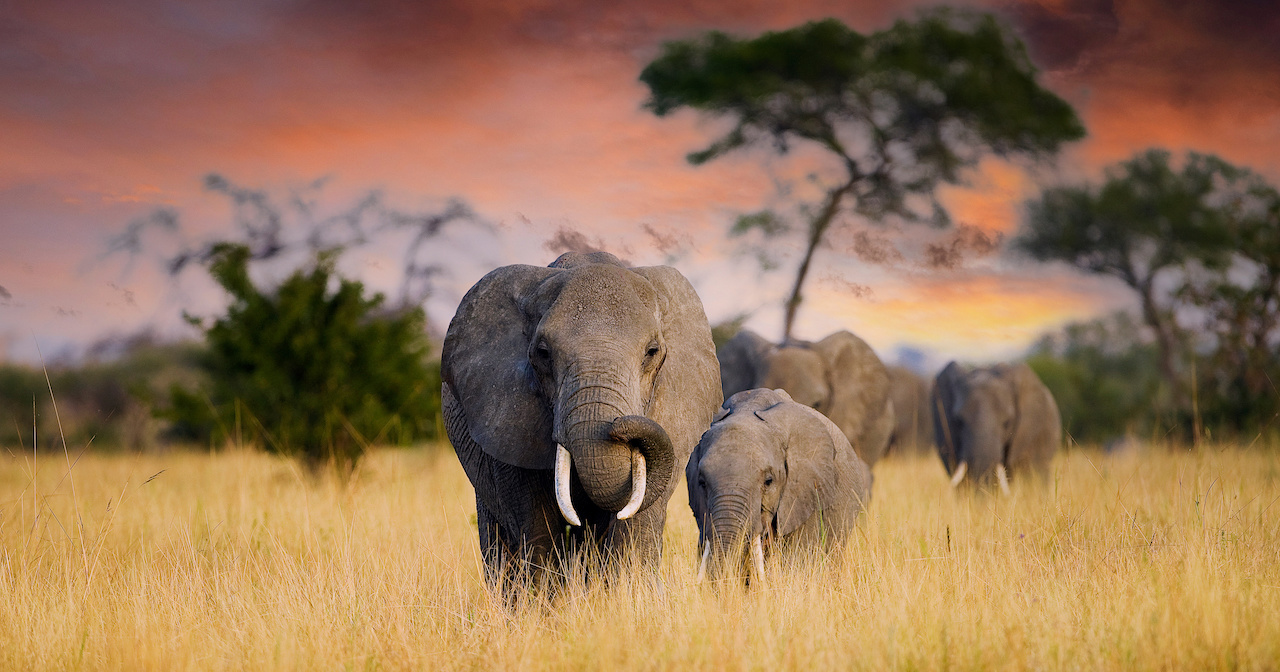
Photo by <a href="https://stock.adobe.com/contributor/19000/mat-hayward?load_type=author&prev_url=detail" >Mat Hayward</a> on Adobe Stock

# Phase 4 Project: *The Met Museum Ivory Art Classification Model*

### By Ryan Posternak and Harrison Carter

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 6th, 2022<br>
Instructor: Joseph Mata

## Goal: Identify whether a piece of artwork among the Met museum's art collection is made of ivory or not

<br>

Limitations:
- Will not catch objects where ivory is only a minor design, or where the ivory may be obscured with paint or other concealer
- Will have false positives for bone/ivory from animals other than elephants, e.g. walrus or mammoth

# Overview and Business Understanding

<br>

Elephants are crucial not only as biological and cultural icons, but as keystone species in their ecosystems. Consisting of  three main species (African Forest, African Savanna, Asian) each serve myriad purposes in their respective environments including habitat creation, seed dispersal, forest pathway creation, brush cover management, among many others. In 1930, an estimated 10 million wild elephants existed on the African continent. After decades of poaching and other human intervention that number declined to approximately 496,000 by 2007. In the following seven years their population was further reduced by 30% to 352,271 according to [The Great Elephant Census](https://en.wikipedia.org/wiki/Great_Elephant_Census), the largest wildlife survey in history.

Each year, poachers kill an estimated 20,000 ([WWF](https://www.worldwildlife.org/species/elephant)) wild elephants for illegal trade, mostly dealing in ivory. With so few of these animals remaining, this leaves precious few years for them on the planet. In 2016, many countries including the United States, United Kingdom, Singapore and others implemented near complete bans on importing and sales of ivory and ivory products. In a massive step China followed suit the following year, disallowing legal sale of ivory within the country, a move that is "widely regarded as the single biggest step to end the slaughter of elephants"([EIA](https://eia-international.org/wildlife/protecting-elephants/saving-elephants-from-the-ivory-trade/)), "eliminating an estimated 70 percent of the global ivory market." ([Smithsonian Magazine](https://www.smithsonianmag.com/science-nature/faking-elephant-ivory-180963226/)). Unfortunately this is not enough, as consumer imports of ivory from abroad are still allowed in China. In places like Vietnam and Thailand, the sale of ivory is illegal in name only, with little to no enforcement and street vendors and jewelry shops alike populating their shelves brazenly. This leads to a wholly unregulated market: between 2009 and 2018 over 56 tons of elephant ivory entered Vietnam's black market and another 20 tons was intercepted in transit ([Sustainability Times](https://www.sustainability-times.com/environmental-protection/from-africa-to-vietnam-the-flow-of-ivory-is-relentess/)).

To combat this, wildlife conservationists are constantly urging countries worldwide to enact stricter legislation, but the emergence of online shopping and peer-to-peer marketplaces presents a major roadblock. Although major websites are able to filter out listings by keyword, there is no way to tell if postings under alternate names or pseudonyms contain ivory objects. Here we have created proof of concept for a machine learning model that takes in image data with regards to a three-dimensional piece of art and separates those that may contain ivory from those that don't. This can be used to identify listings potentially containing ivory contraband and flag them for further investigation.

<br>

# Data Understanding

<br>

Data for this project was sourced from <a href="https://www.metmuseum.org/art/collection/search?pageSize=0&sortBy=Relevance&sortOrder=asc&searchField=All" >The Metropolitan Museum of Art in New York City</a>. The museum, which hosts a collection of nearly half a million paintings, drawings, sculptures, and other artifacts spanning over 5,000 years of history, has open-sourced data on nearly all of the items in their collection through their <a href="https://metmuseum.github.io" >Collection API</a>. The API is freely available for commercial and non-commercial use, and requires no API key to use the service.

Artifacts are searched for in the API via the object's "objectId". The search returns a dictionary with 57 items of information on everything from the artifact's department, title, artist name, medium(s) of art, region, and measurements, although many of the fields are blank for most items. The museum provides images for most artifacts in the API, through specific keys in the return dictionary linking to URLs containing the jpeg images.

For this project, we first searched for artifacts that have the word "ivory" listed among the object's medium(s). These artifacts formed the initial collection of ivory art pieces that we used to train our neural network. For non-ivory object images to train the neural network, we searched for objects that contained "ceramic" listed among the medium(s), as we reasoned that ceramic figures which be of a similar size and shape as most ivory objects, thus making them a difficult comparison against the ivory artifacts for the neural networks to classify.

After further exploration of the data, we discovered that many of the artifacts in our initial collection of ivory objects (all artifacts listing ivory as a medium) contained many pieces where ivory was only a minor component of the design of the artifact. In many of these cases, even human analysis could not accurately determine whether ivory was a component of the artifact or not. For this reason, we decided to limit our collection of ivory artifacts that we passed into the models to objects where ivory was the sole component.

<br>

# Sourcing the Data

### Import libraries, packages and modules

In [1]:
# Numpy, pandas, file management, and miscellaneous imports
import numpy as np
import pandas as pd
import requests
import time
import random
from PIL import Image
import imagesize
from pathlib import Path
from io import BytesIO
import os
import shutil
import joblib

# Keras and sklearn imports
from tensorflow import keras
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras import regularizers
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualizations imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%matplotlib inline

### Connect to Met API

In [2]:
# API URL to obtain IDs of ivory objects
ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ivory&q=*'

# API URL to obtain IDs of (expected to be) non-ivory ceramic objects
non_ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ceramics&hasImages=true&q=*'

# Ivory objects request
ivory_r = requests.get(ivory_url)

# Non-ivory objects request
non_ivory_r = requests.get(non_ivory_url)

ivory_r.status_code, non_ivory_r.status_code

(200, 200)

In [3]:
# Retrieve objectIds
ivory_objectIDs = ivory_r.json()['objectIDs']
non_ivory_objectIDs = non_ivory_r.json()['objectIDs']


print(f"Number of ivory objects: {len(ivory_objectIDs)}")
print(f"Number of ceramic objects: {len(non_ivory_objectIDs)}")

Number of ivory objects: 5975
Number of ceramic objects: 25603


In [4]:
# Let's view the full data on one museum art piece (the first ivory object in our list)
url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

requests.get(url + str(ivory_objectIDs[0])).json()

{'objectID': 248694,
 'isHighlight': False,
 'accessionNumber': '12.229.23b',
 'accessionYear': '1912',
 'isPublicDomain': True,
 'primaryImage': 'https://images.metmuseum.org/CRDImages/gr/original/sf1222923b.jpg',
 'primaryImageSmall': 'https://images.metmuseum.org/CRDImages/gr/web-large/sf1222923b.jpg',
 'additionalImages': [],
 'constituents': None,
 'department': 'Greek and Roman Art',
 'objectName': 'Relief of a duck',
 'title': 'Relief of a duck',
 'culture': 'Roman',
 'period': 'Early Imperial',
 'dynasty': '',
 'reign': '',
 'portfolio': '',
 'artistRole': '',
 'artistPrefix': '',
 'artistDisplayName': '',
 'artistDisplayBio': '',
 'artistSuffix': '',
 'artistAlphaSort': '',
 'artistNationality': '',
 'artistBeginDate': '',
 'artistEndDate': '',
 'artistGender': '',
 'artistWikidata_URL': '',
 'artistULAN_URL': '',
 'objectDate': '1st century A.D.',
 'objectBeginDate': 1,
 'objectEndDate': 99,
 'medium': 'Bone',
 'dimensions': '1 13/16 × 5/8 × 4 3/16 in. (4.7 × 1.6 × 10.6 cm)',

### Create container lists with selected attributes

In [5]:
# Initialize lists
ivory_primaryImageSmall_urls = []
ivory_titles = []
ivory_objectNames = []
ivory_mediums = []
ivory_classifications = []
ivory_departments = []
ivory_cultures = []
ivory_periods = []
ivory_objectDates = []

# Compile containers
attribute_containers = [ivory_primaryImageSmall_urls, ivory_titles, ivory_objectNames, ivory_mediums, 
                        ivory_classifications, ivory_departments, ivory_cultures, ivory_periods, ivory_objectDates]

# Compile key names of attributes
attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
              'classification', 'department', 'culture', 'period', 'objectDate']

# Execute API requests
objects_url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

# Prevent running duplicate API requests
if os.path.isfile('data/ivory_df.csv') == False:
    for objectID in ivory_objectIDs:
        r = requests.get(objects_url + str(objectID))
        for attribute_container, attribute in zip(attribute_containers, attributes):
            try:
                attribute_container.append(r.json()[attribute])
            except:
                attribute_container.append(np.nan)  # Some keys are missing on select objects
        time.sleep(1/80)  # Throttle API request rate to conform with API documentation

### Create dataframe of ivory art pieces

In [6]:
# Only run if ivory_df has not been saved to data/ folder yet
try:
    ivory_df = pd.DataFrame(ivory_objectIDs, columns=['Object_ID'])

    ivory_df['Image_URL'] = ivory_primaryImageSmall_urls
    ivory_df['Title'] = ivory_titles
    ivory_df['Object_Name'] = ivory_objectNames
    ivory_df['Medium'] = ivory_mediums
    ivory_df['Classification'] = ivory_classifications
    ivory_df['Department'] = ivory_departments
    ivory_df['Culture'] = ivory_cultures
    ivory_df['Period'] = ivory_periods
    ivory_df['Object_Date'] = ivory_objectDates

    # Ivory art pieces will have class labels of 1
    ivory_df['Target'] = 1
    # Replace blank (missing) values with NaN
    ivory_df.replace(to_replace='', value=np.nan, inplace=True)

    print(ivory_df.shape)
    display(ivory_df.head())

except:
    ivory_df = pd.read_csv('data/ivory_df.csv', index_col=0)
    
    print(ivory_df.shape)
    display(ivory_df.head())

(5975, 11)


Object_ID                                          Image_URL  \
0     248694  https://images.metmuseum.org/CRDImages/gr/web-...   
1     248695  https://images.metmuseum.org/CRDImages/gr/web-...   
2     257575  https://images.metmuseum.org/CRDImages/gr/web-...   
3      25138                                                NaN   
4      25137                                                NaN   

               Title        Object_Name                             Medium  \
0   Relief of a duck   Relief of a duck                               Bone   
1  Relief of a child  Relief of a child                               Bone   
2         Eye inlays         Eye inlays                        Bone, ivory   
3   Dirk with Sheath   Dirk with sheath        Steel, ivory, leather, gold   
4          Cinquedea          Cinquedea  Steel, brass, ivory, gold, latten   

              Classification           Department  Culture          Period  \
0  Miscellaneous-Bone, Ivory  Greek and Roman Art    Roman  Early Imperial   
1  Miscellaneous-Bone, Ivory  Greek and Roman Art      NaN             NaN   
2  Miscellaneous-Bone, Ivory  Greek and Roman Art      NaN             NaN   
3                    Daggers       Arms and Armor   French             NaN   
4                    Daggers       Arms and Armor  Italian             NaN   

        Object_Date  Target  
0  1st century A.D.       1  
1               NaN       1  
2               NaN       1  
3      16th century       1  
4           1525–50       1

### Save dataframe to data folder

In [7]:
# Only save the dataframe if it doesn't already exist yet
if os.path.isfile('data/ivory_df.csv') == False:
    ivory_df.to_csv('data/ivory_df.csv')
else:
    pass

In [8]:
# How many of the ivory objects have valid (small) image URLs?
num_ivory_objects_with_image = ivory_df.shape[0] - ivory_df.Image_URL.isna().sum()
num_ivory_objects_with_image

4617

In [9]:
# Choose 5,975 random objectIds from the non_ivory_objectIDs list
np.random.seed(10)
selected_non_ivory_objectIDs = np.random.choice(non_ivory_objectIDs, size=5975, replace=False)
print(f"{len(selected_non_ivory_objectIDs)} object IDs selected from non_ivory_objectIDs list")

5975 object IDs selected from non_ivory_objectIDs list


### Repeat steps above to create dataframe of non-ivory art pieces

In [10]:
non_ivory_primaryImageSmall_urls = []
non_ivory_titles = []
non_ivory_objectNames = []
non_ivory_mediums = []
non_ivory_classifications = []
non_ivory_departments = []
non_ivory_cultures = []
non_ivory_periods = []
non_ivory_objectDates = []

attribute_containers = [non_ivory_primaryImageSmall_urls, non_ivory_titles, non_ivory_objectNames, 
                        non_ivory_mediums, non_ivory_classifications, non_ivory_departments, non_ivory_cultures, 
                        non_ivory_periods, non_ivory_objectDates]

attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
              'classification', 'department', 'culture', 'period', 'objectDate']

if os.path.isfile('data/final_df.csv') == False:
    for objectID in selected_non_ivory_objectIDs:
        r = requests.get(objects_url + str(objectID))
        for attribute_container, attribute in zip(attribute_containers, attributes):
            try:
                attribute_container.append(r.json()[attribute])
            except:
                attribute_container.append(np.nan)
        time.sleep(1/80)

In [11]:
# Only run if non_ivory_df has not been saved to data/ folder yet
try:
    non_ivory_df = pd.DataFrame(selected_non_ivory_objectIDs, columns=['Object_ID'])

    non_ivory_df['Image_URL'] = non_ivory_primaryImageSmall_urls
    non_ivory_df['Title'] = non_ivory_titles
    non_ivory_df['Object_Name'] = non_ivory_objectNames
    non_ivory_df['Medium'] = non_ivory_mediums
    non_ivory_df['Classification'] = non_ivory_classifications
    non_ivory_df['Department'] = non_ivory_departments
    non_ivory_df['Culture'] = non_ivory_cultures
    non_ivory_df['Period'] = non_ivory_periods
    non_ivory_df['Object_Date'] = non_ivory_objectDates

    # Non-ivory art pieces will have class labels of 0
    non_ivory_df['Target'] = 0
    # Replace blank (missing) values with NaN
    non_ivory_df.replace(to_replace='', value=np.nan, inplace=True)
    # Remove objects without valid (small) image URLs
    non_ivory_df.dropna(subset=['Image_URL'], inplace=True)
    
    print(non_ivory_df.shape)
    display(non_ivory_df.head())
    
except:
    non_ivory_df = pd.read_csv('data/non_ivory_df.csv', index_col=0)
    print(non_ivory_df.shape)
    display(non_ivory_df.head())

(5320, 11)


Object_ID                                          Image_URL  \
0     186685  https://images.metmuseum.org/CRDImages/es/web-...   
1     194344  https://images.metmuseum.org/CRDImages/es/web-...   
2      47555  https://images.metmuseum.org/CRDImages/as/web-...   
4      48435  https://images.metmuseum.org/CRDImages/as/web-...   
6     695250  https://images.metmuseum.org/CRDImages/md/web-...   

                                            Title       Object_Name  \
0  Bowl with Saint Francis receiving the stigmata              Bowl   
1                                           Plate             Plate   
2                                           Plate             Plate   
4                                Model of a stove  Model of a stove   
6                                        Fragment          Fragment   

                                        Medium    Classification  \
0  Maiolica (tin-glazed earthenware), lustered  Ceramics-Pottery   
1             Faience (tin-glazed earthenware)  Ceramics-Pottery   
2                                    Porcelain          Ceramics   
4                 Earthenware with green glaze      Tomb Pottery   
6                               Glass, ceramic     Glass-Vessels   

                               Department                     Culture  \
0  European Sculpture and Decorative Arts                         NaN   
1  European Sculpture and Decorative Arts                         NaN   
2                               Asian Art                       China   
4                               Asian Art                       China   
6                            Medieval Art  European or Middle Eastern   

                            Period        Object_Date  Target  
0                              NaN       16th century       0  
1                              NaN          1730–1800       0  
2         Ming dynasty (1368–1644)                NaN       0  
4  Han dynasty (206 B.C.–A.D. 220)    1st–2nd century       0  
6                              NaN  ca. 1150–ca. 1250       0

### Save dataframe to data folder

In [12]:
# Only save the dataframe if it doesn't already exist yet
if os.path.isfile('data/non_ivory_df.csv') == False:
    non_ivory_df.to_csv('data/non_ivory_df.csv')
else:
    pass

### Concatenate dataframes

In [13]:
merged_df = pd.concat([ivory_df, non_ivory_df], ignore_index=True)
print(merged_df.shape)
merged_df.head()

(11295, 11)


Object_ID                                          Image_URL  \
0     248694  https://images.metmuseum.org/CRDImages/gr/web-...   
1     248695  https://images.metmuseum.org/CRDImages/gr/web-...   
2     257575  https://images.metmuseum.org/CRDImages/gr/web-...   
3      25138                                                NaN   
4      25137                                                NaN   

               Title        Object_Name                             Medium  \
0   Relief of a duck   Relief of a duck                               Bone   
1  Relief of a child  Relief of a child                               Bone   
2         Eye inlays         Eye inlays                        Bone, ivory   
3   Dirk with Sheath   Dirk with sheath        Steel, ivory, leather, gold   
4          Cinquedea          Cinquedea  Steel, brass, ivory, gold, latten   

              Classification           Department  Culture          Period  \
0  Miscellaneous-Bone, Ivory  Greek and Roman Art    Roman  Early Imperial   
1  Miscellaneous-Bone, Ivory  Greek and Roman Art      NaN             NaN   
2  Miscellaneous-Bone, Ivory  Greek and Roman Art      NaN             NaN   
3                    Daggers       Arms and Armor   French             NaN   
4                    Daggers       Arms and Armor  Italian             NaN   

        Object_Date  Target  
0  1st century A.D.       1  
1               NaN       1  
2               NaN       1  
3      16th century       1  
4           1525–50       1

<br>

# Exploratory Data Analysis

### Examine Distribution of Ivory Art Pieces by Department

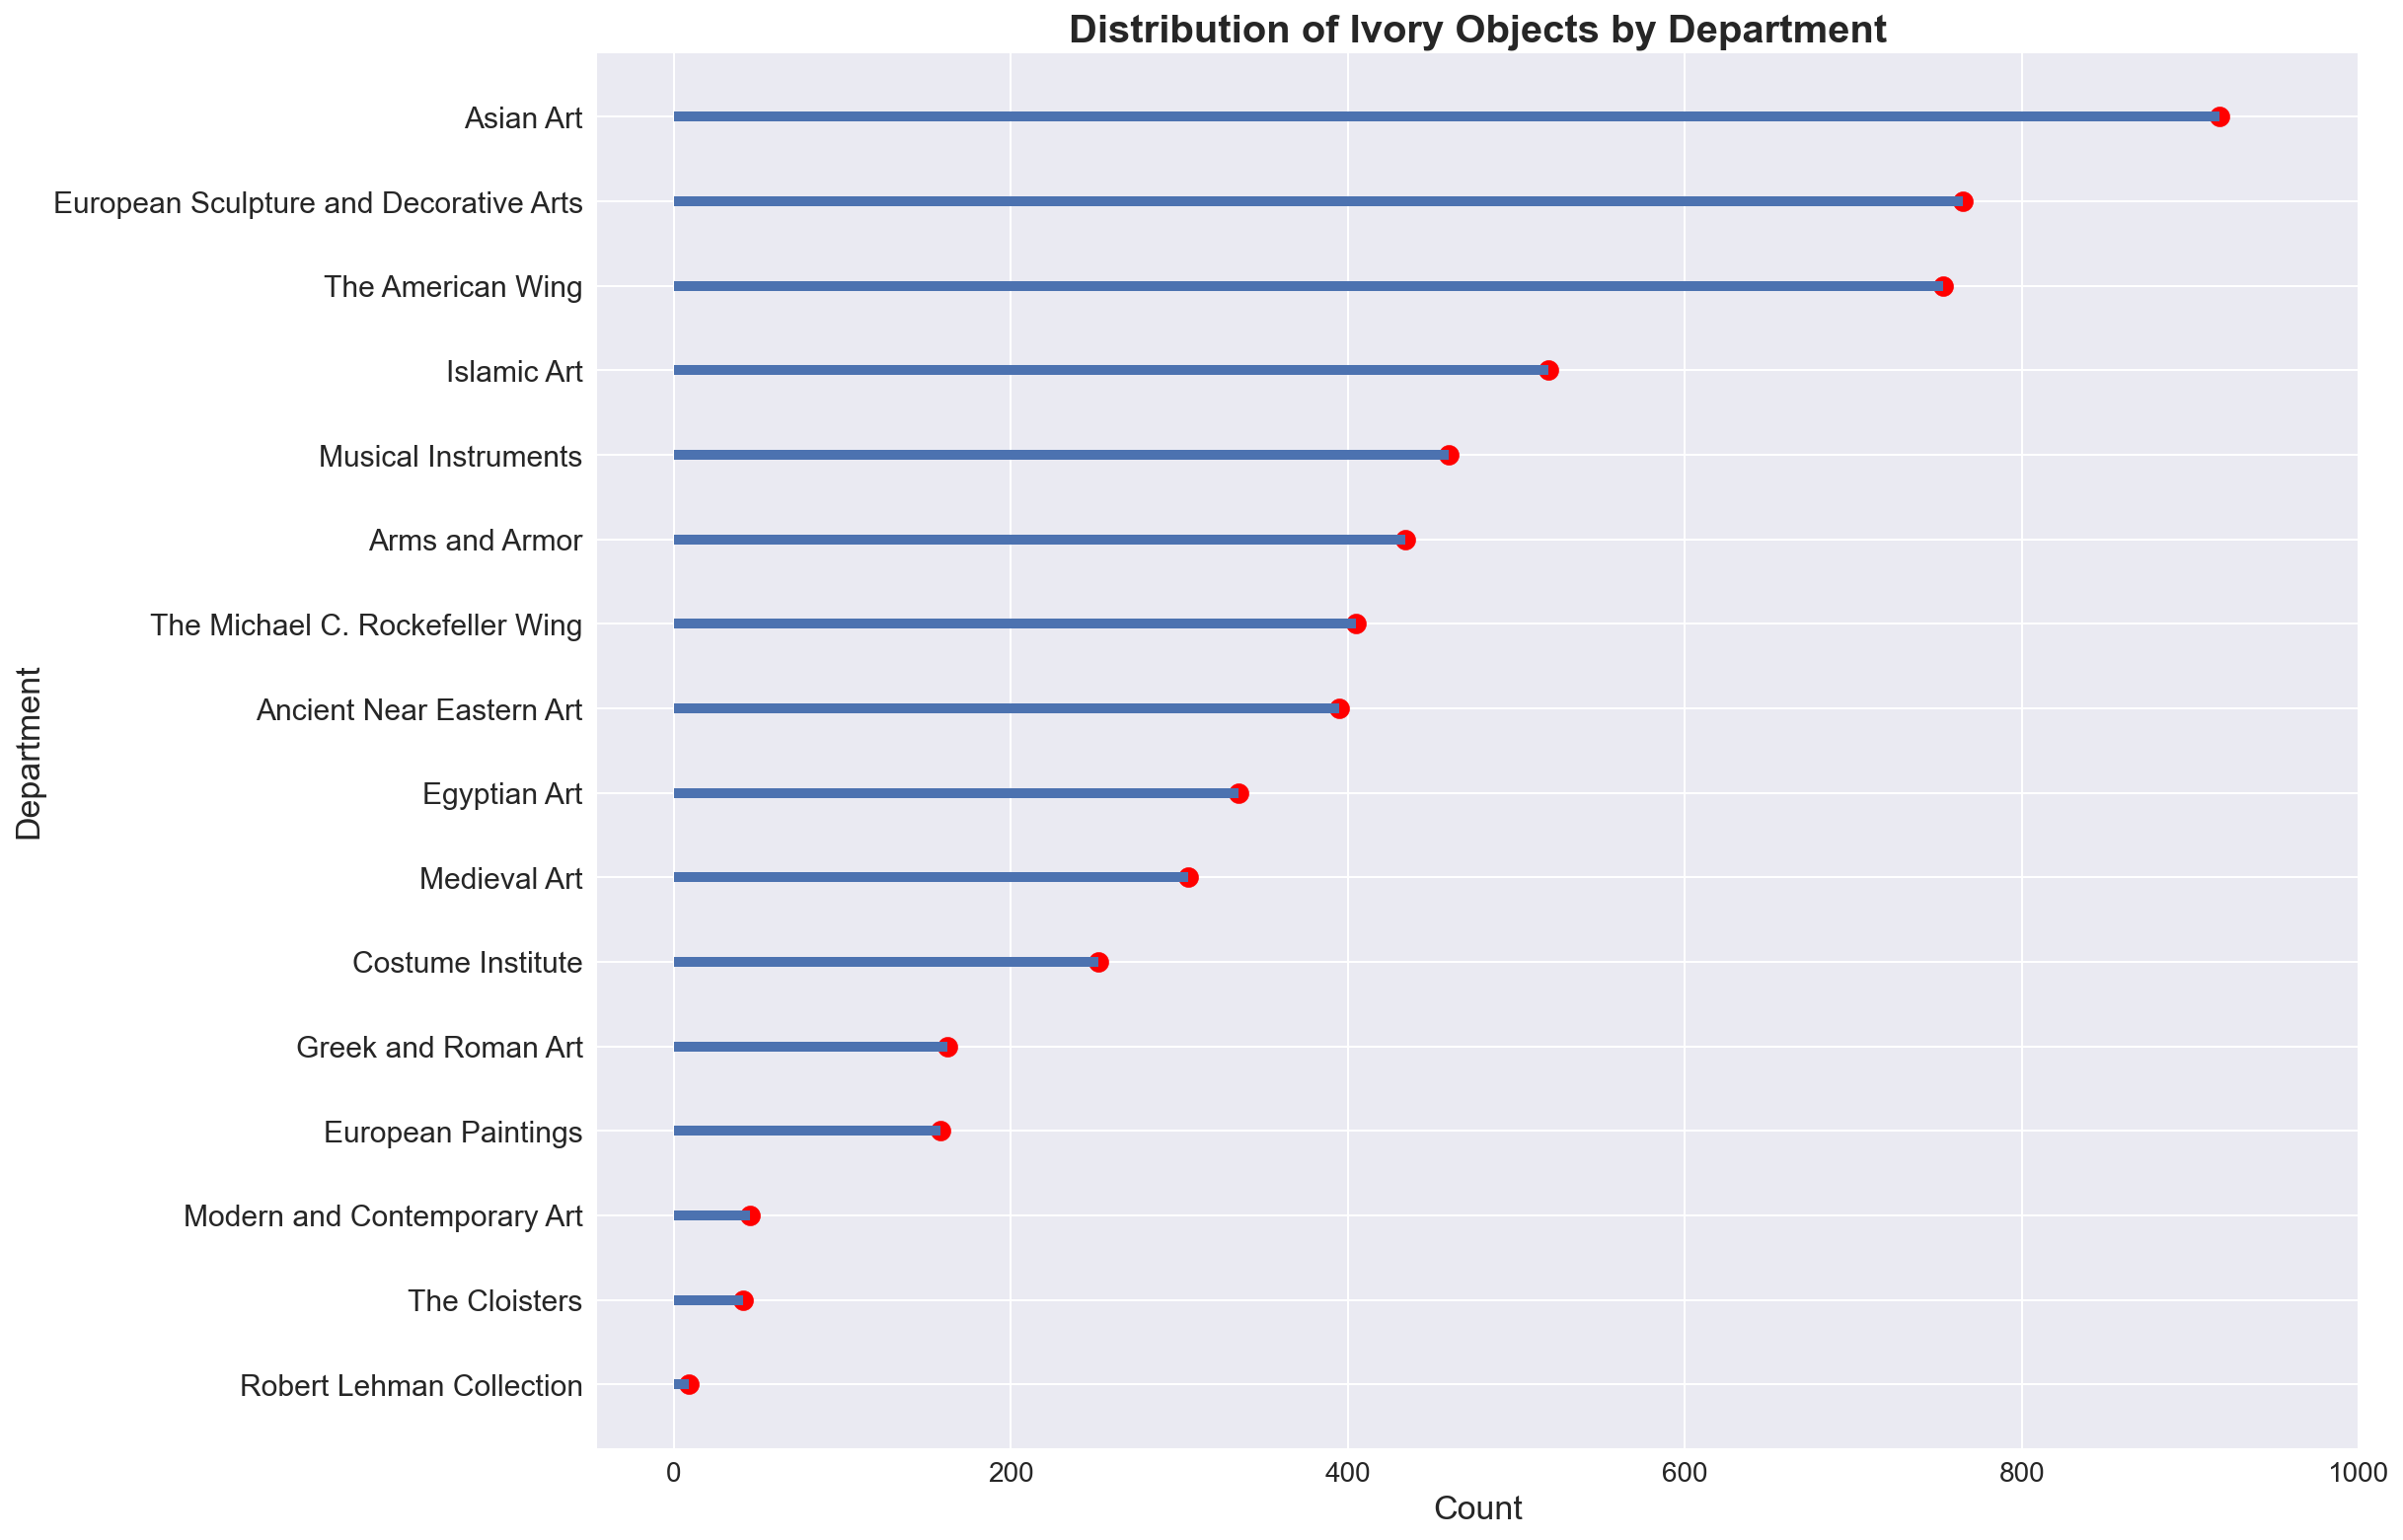

In [14]:
departments = list(ivory_df.Department.value_counts().index)
counts = list(ivory_df.Department.value_counts().values)

fig, ax = plt.subplots(figsize=(16, 13))

# Plot horizontal lines
plt.hlines(departments[::-1], linewidths=5, xmin=0, xmax=counts[::-1])

# Plot circles
plt.scatter(counts[::-1], departments[::-1], color='red', alpha=1, s=100)

# sns.barplot(x=counts, y=departments)
plt.title('Distribution of Ivory Objects by Department', fontsize=20, fontweight='bold')
plt.xlabel('Count', fontsize=17)
plt.ylabel('Department', fontsize=17)
plt.yticks(size=15)
plt.xticks(range(0, 1200, 200), size=14);

### Examine Distribution of Ivory Art Pieces by Object Date

Let's first examine how the Met encoded the objectDate field for their items

In [15]:
print(ivory_df.Object_Date.value_counts().index.shape[0], 'unique values in Object_Date column of ivory_df')
ivory_df.Object_Date.value_counts()[:20]

1287 unique values in Object_Date column of ivory_df


19th century                    719
18th century                    292
9th–10th century                206
18th–19th century               165
late 19th century                91
ca. 9th–8th century B.C.         89
ca. 18th century B.C.            87
17th century                     83
ca. 8th–7th century B.C.         77
late 19th–early 20th century     72
19th–20th century                64
late 18th century                59
ca. 9th century B.C.             55
14th–15th century                51
14th century                     45
early 19th century               45
20th century                     45
13th–14th century                42
ca. 1835                         40
mid-19th century                 38
Name: Object_Date, dtype: int64

**Remarks:**
- We have a whole lot of unique values in the Object_Date column of our ivory dataframe - almost 1,300. The values look pretty messy as well, with no consistent formatting. Some values are a single century, some are a range of centuries or parts of centuries, some are specific years, etc. This will require a fair bit of processing to work with, and will inevitably not be a fully accurate encapsulation, but we'll proceed nonetheless.

In [16]:
twentieth = 0
nineteenth = 0
eighteenth = 0
seventeenth = 0
sixteenth = 0
fifteenth = 0
fourteenth = 0
pre_fourteenth_AD = 0
BC = 0

for date, count in zip(ivory_df.Object_Date.value_counts().index, ivory_df.Object_Date.value_counts().values):
    if 'B.C.' in date or 'BC' in date:
        BC += count
    elif '20th' in date:
        twentieth += count
    elif '19th' in date:
        nineteenth += count
    elif '18th' in date:
        eighteenth += count
    elif '17th' in date:
        seventeenth += count
    elif '16th' in date:
        sixteenth += count
    elif '15th' in date:
        fifteenth += count
    elif '14th' in date:
        fourteenth += count
    elif '19' in date and 'ca' in date:
        twentieth += count
    elif '18' in date and 'ca' in date:
        nineteenth += count
    elif '17' in date and 'ca' in date:
        eighteenth += count
    elif '16' in date and 'ca' in date:
        seventeenth += count
    elif '15' in date and 'ca' in date:
        sixteenth += count
    elif '14' in date and 'ca' in date:
        fifteenth += count
    elif '13' in date and 'ca' in date:
        fourteenth += count
    else:
        pre_fourteenth_AD += count
    
strings = ['20th Century', '19th Century', '18th Century', '17th Century', '16th Century', '15th Century', 
           '14th Century', 'Pre-14th Century AD', 'BC']
counts = [twentieth, nineteenth, eighteenth, seventeenth, sixteenth, fifteenth, fourteenth, 
          pre_fourteenth_AD, BC]
    
dates_df = pd.DataFrame([strings, counts]).T
dates_df.rename({0: 'Date', 1: 'Count'}, axis=1, inplace=True)
dates_df['Count'] = dates_df['Count'].astype(int)

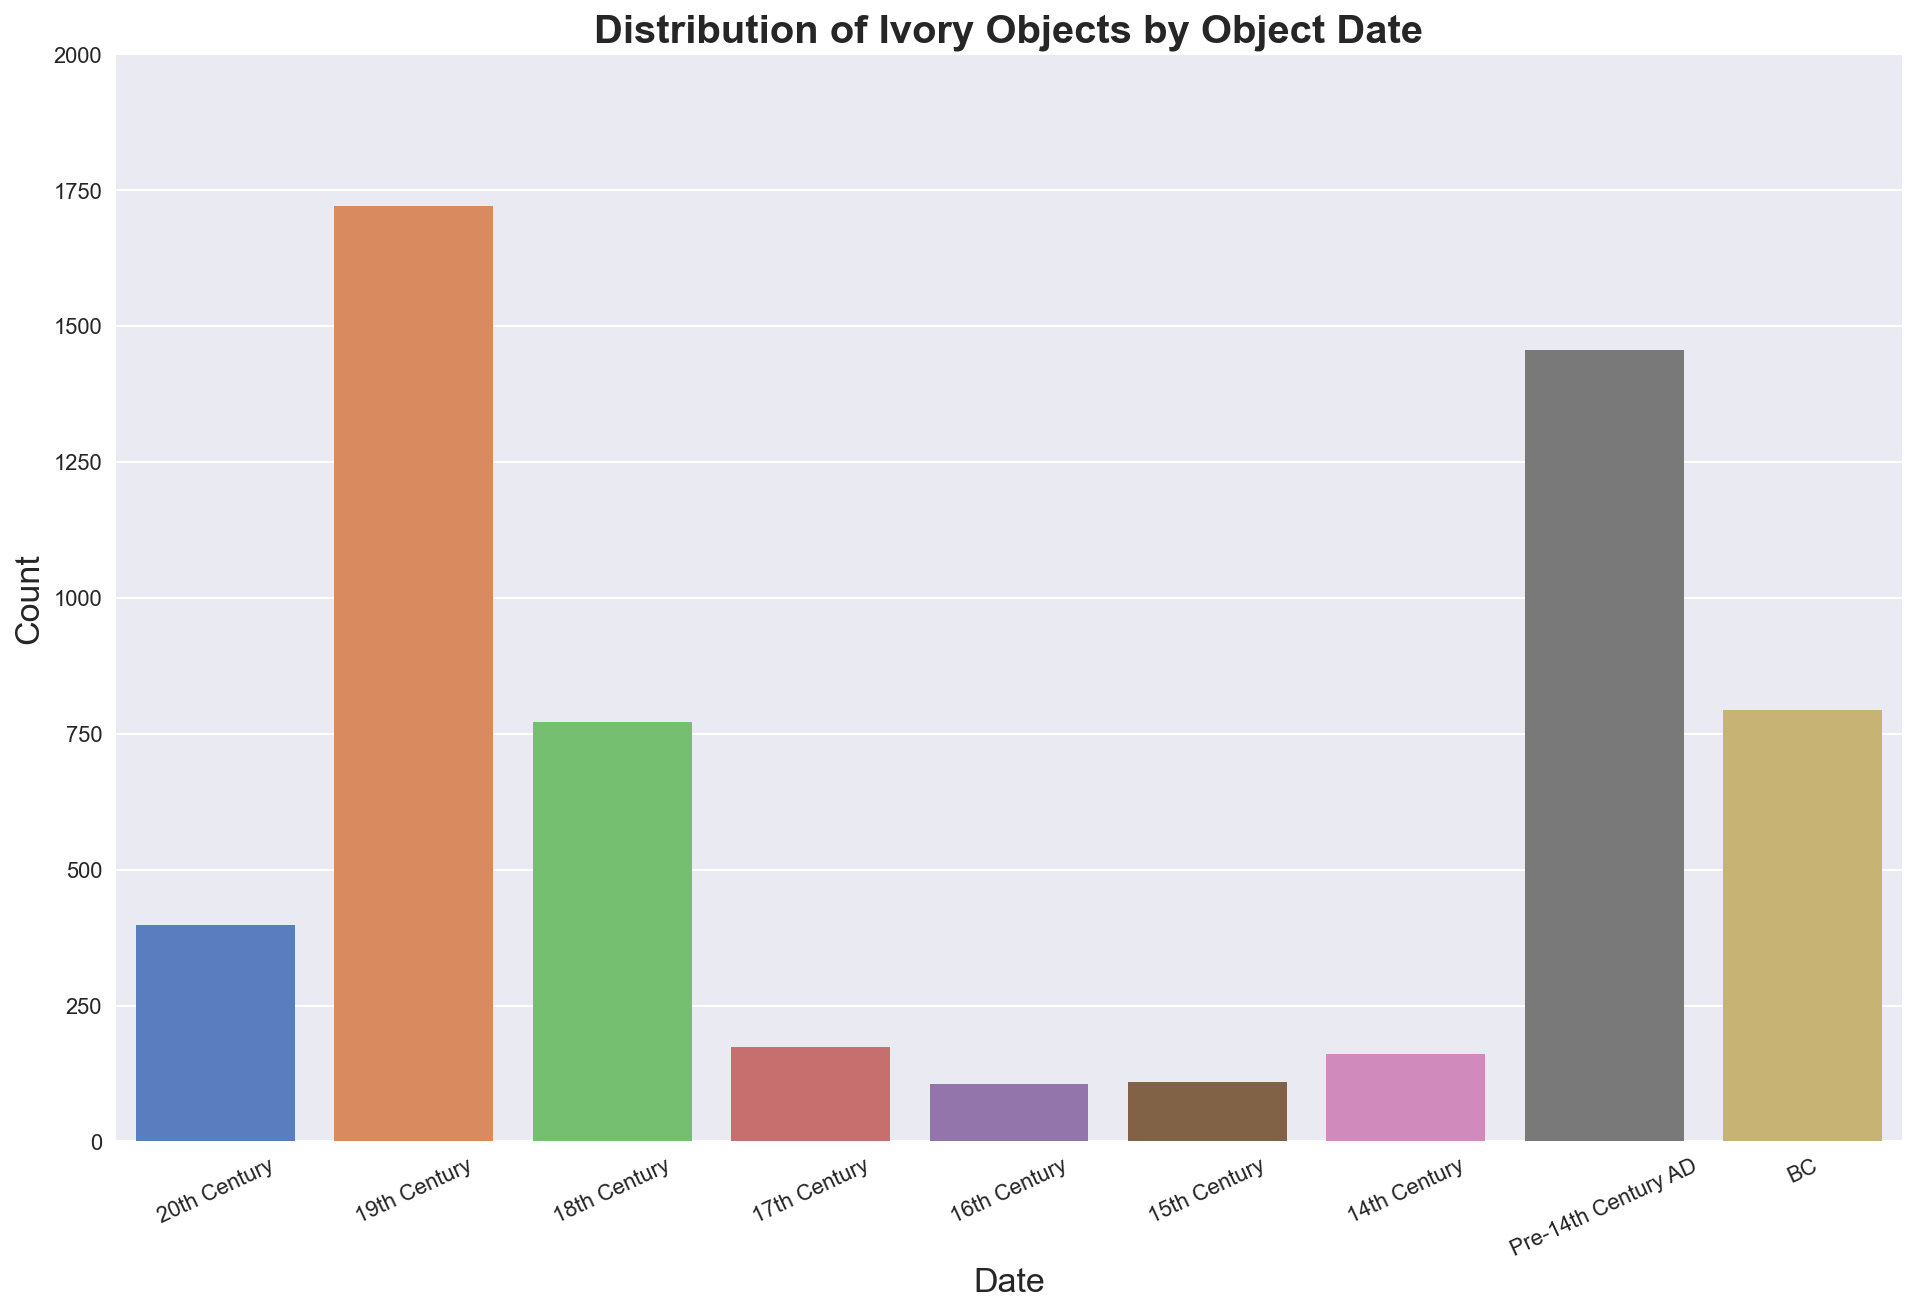

In [17]:
fig, ax = plt.subplots(figsize=(16, 10))

sns.barplot(x='Date', y='Count', data=dates_df, palette='muted')
plt.title('Distribution of Ivory Objects by Object Date', fontsize=20, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=25)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Count', fontsize=17)
plt.yticks(ax.get_yticks(), size=11)
plt.xticks(ax.get_xticks(), size=11);

**Remarks:**
- It looks like many of the ivory artifacts in the collection are quite dated. This could mean that they are not fully representative of the ivory artifacts that are being produced in modern times - something to keep in mind.

### Examine Distribution of Number of Components (Materials) Comprising Ivory Artifacts

In [18]:
# Let's view what split lists of some of the unique indexes of materials look like
np.random.seed(10)
component_count_dict = {}

for medium in np.random.choice(ivory_df.Medium.value_counts().index, 10):
    num_components = len(medium.replace('and', ',').split(','))
    print(medium.replace('and', ',').split(','))

['ostrish egg', ' wood', ' ivory', ' wire']
['Wood (pine', ' beech) steel', ' ivory', ' horn (cow)', ' bone', ' pigment', ' gold']
['Carved ivory with green glass stopper']
['ivory', ' paper', ' gouache', ' mother-of-pearl', ' metal', ' metallic']
['Steel', ' ivory', ' copper alloy', ' gold', ' leather']
['Leather', ' cowhorn', ' ivory', ' linen', ' cotton', ' wood']
['Steel', ' iron', ' ivory', ' brass', ' gold']
['Ebony', ' sharkskin', ' ivory', ' brass']
['Amber', ' silver gilt', ' mica ', ' ivory (?)']
['Ivory', ' silk', ' metallic thread']


In [19]:
component_count_dict = {}

for mediums, count in zip(list(ivory_df.Medium.value_counts().index), list(ivory_df.Medium.value_counts())):
    component_lists = mediums.replace('and', ',').split(',')
    num_components, frequency = len(component_lists), count
    if num_components not in component_count_dict and num_components < 6:
        component_count_dict[num_components] = frequency
    elif num_components in component_count_dict and num_components < 6:
        component_count_dict[num_components] += frequency
    elif '6+' not in component_count_dict:
        component_count_dict['6+'] = frequency
    elif num_components not in component_count_dict:
        component_count_dict['6+'] += frequency

component_count_dict

{1: 3189, 2: 1066, 4: 490, 3: 623, 5: 268, '6+': 319}

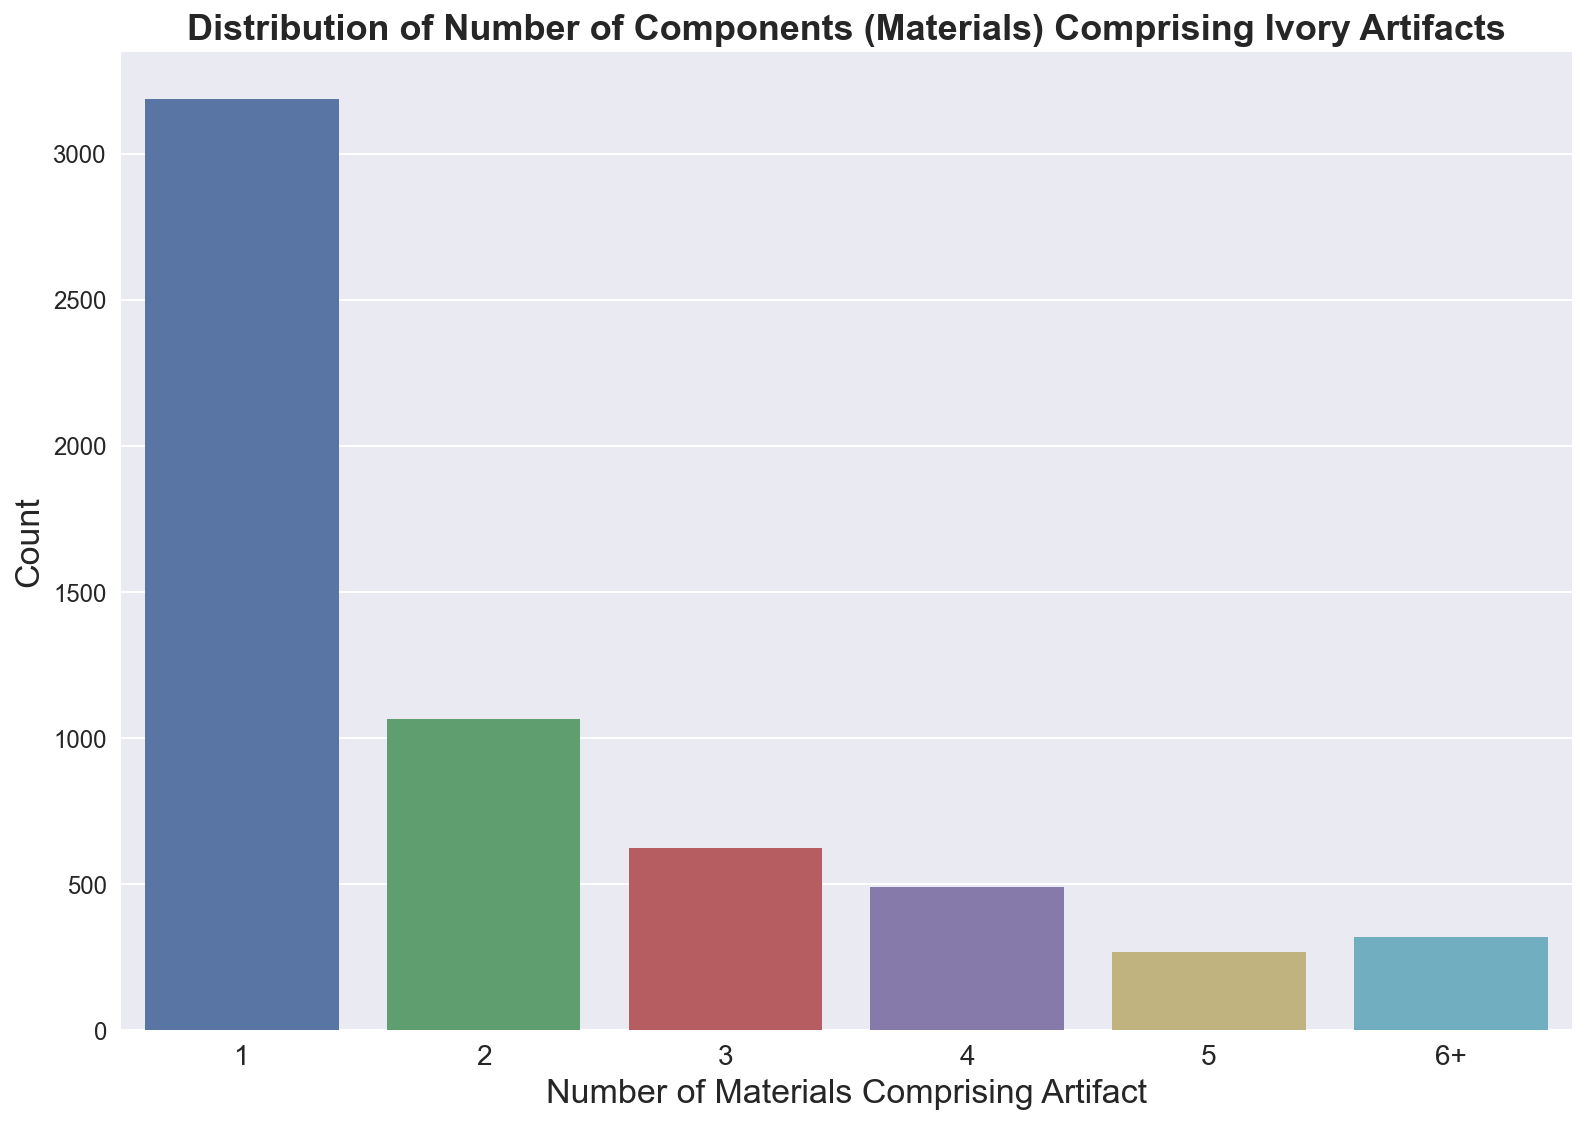

In [20]:
fig, ax = plt.subplots(figsize=(13, 9))

component_count_dict = {'1': 3189, '2': 1066, '3': 623, '4': 490, '5': 268, '6+': 319}

components_df = pd.DataFrame([component_count_dict.keys(), component_count_dict.values()]).T
components_df.columns=['num_components', 'count']

sns.barplot(x='num_components', y='count', data=components_df)
plt.title('Distribution of Number of Components (Materials) Comprising Ivory Artifacts', fontsize=18, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels())
plt.xlabel('Number of Materials Comprising Artifact', fontsize=17)
plt.ylabel('Count', fontsize=17)
plt.yticks(range(0, 3500, 500), size=12)
plt.xticks(size=14);

**Remarks:**
- It looks like about half of the artifacts are comprised of just one material (presumably ivory), while the other half are comprised of multiple materials. The artifacts comprised of multiple materials may make it difficult for the neural network to pick up on the ivory in the artifact, especially if ivory is a small or minor component of the art piece.

<br>

# Data Preprocessing

### Drop duplicate object IDs, null image URLs, and duplicate image URLs

In [21]:
print('Before preprocessing:' + '\n')

# Search for duplicate Object_IDs
num_dup_IDs = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]
print(str(num_dup_IDs) + ' duplicate Object_IDs')

# Remove from dataframe (keep first occurrence)
dup_ID_indexes = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].index
merged_df = merged_df.drop(dup_ID_indexes)

# Search for NaN Image_URLs
num_NaN_Image_URLs = merged_df.loc[merged_df['Image_URL'].isna()].shape[0]
print(str(num_NaN_Image_URLs) + ' null Image_URLs')

# Remove from dataframe
NaN_Image_URL_indexes = merged_df.loc[merged_df['Image_URL'].isna()].index
merged_df = merged_df.drop(NaN_Image_URL_indexes)

# Search for duplicate Image_URLs
num_dup_Image_URLs = merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]
print(str(num_dup_Image_URLs) + ' duplicate Image_URLs')

# Remove from dataframe (keep first occurrence)
dup_Image_URL_indexes = merged_df.loc[merged_df.duplicated(subset='Image_URL')].index
merged_df = merged_df.drop(dup_Image_URL_indexes)

print('-'*30)
print('After preprocessing:' + '\n')
print(str(merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]) + ' duplicate Object_IDs')
print(str(merged_df.loc[merged_df['Image_URL'].isna()].shape[0]) + ' null Image_URLs')
print(str(merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]) + ' duplicate Image_URLs')

Before preprocessing:

22 duplicate Object_IDs
1358 null Image_URLs
160 duplicate Image_URLs
------------------------------
After preprocessing:

0 duplicate Object_IDs
0 null Image_URLs
0 duplicate Image_URLs


### Drop art pieces where ivory is only a minor element of the design

In [22]:
# Let's preview the mediums of our ivory objects
merged_df.loc[merged_df.Target == 1].Medium.value_counts()[:30]

Ivory                                           1382
Watercolor on ivory                              562
Bone                                             140
Bone; incised and inlaid with paint              125
Bone; tinted, incised, and inlaid with paint      53
Elephant ivory                                    53
Bone; carved                                      32
Wood; carved, inlaid with ivory                   31
Ivory (walrus)                                    31
ivory                                             27
Walrus ivory                                      26
Steel, ivory                                      23
Bone; incised                                     23
Ivory with metal mounts                           20
Ivory or bone                                     19
Wood, ivory                                       17
Paper, ivory                                      17
Silver, ivory                                     16
Wood; inlaid with ivory                       

4230
Ivory


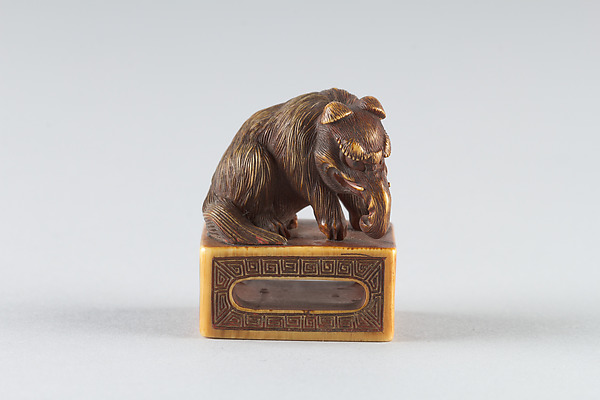

1658
Ivory


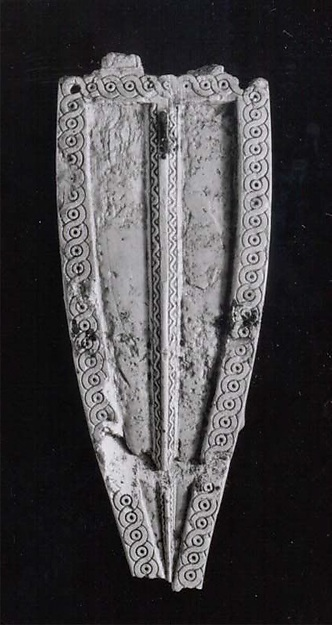

1853
Ivory


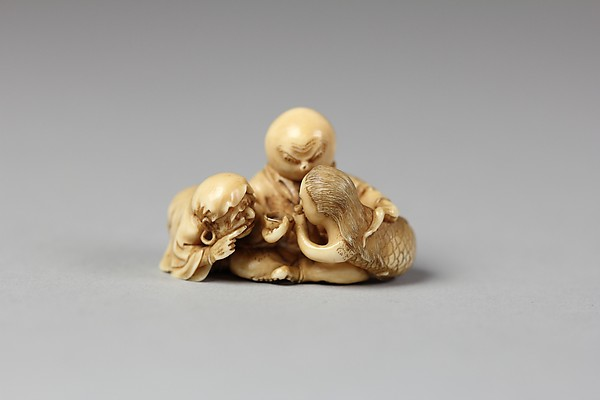

In [23]:
# These are the art mediums that appear most relevant to our search for ivory objects. The others might hardly 
# have any trace of bone/ivory for the model to pick up on. We'll also include other forms of ivory besides 
# elephant ivory, such as walrus ivory, due to the similarity in appearance.
ivory_indexes_to_keep = merged_df.loc[(merged_df.Medium == 'Ivory') | 
                                      (merged_df.Medium == 'Bone') | 
                                      (merged_df.Medium == 'Bone, ivory') | 
                                      (merged_df.Medium == 'Elephant ivory') | 
                                      (merged_df.Medium == 'Bone; carved') | 
                                      (merged_df.Medium == 'Ivory (walrus)') | 
                                      (merged_df.Medium == 'ivory') | 
                                      (merged_df.Medium == 'Walrus ivory') | 
                                      (merged_df.Medium == 'Bone; incised') | 
                                      (merged_df.Medium == 'Ivory with metal mounts') | 
                                      (merged_df.Medium == 'Ivory or bone') | 
                                      (merged_df.Medium == 'Ivory (elephant)')
                                     ].index

# Let's preview three items from above
np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

970
Wood; carved, inlaid with plain and carved ivory


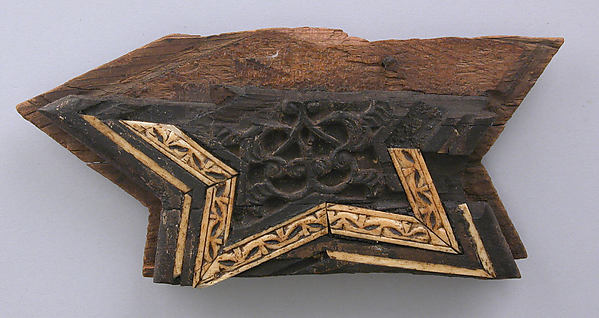

5948
Ivory, gold


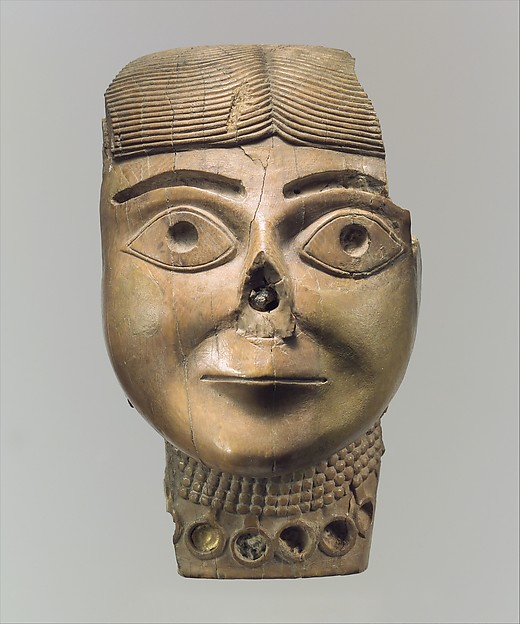

2649
Carved ivory; mounted over wood frame; brass mounts


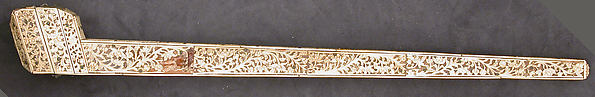

In [24]:
# Just to be sure, let's preview three items that don't fit the medium descriptions above, to see if they are 
# still recognizable as ivory or not
all_ivory_indexes = merged_df.loc[merged_df.Target == 1].index
ivory_indexes_to_drop = [index for index in all_ivory_indexes if index not in ivory_indexes_to_keep]

np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_drop, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

**Remarks**:
- As suspected, the images not among the selected mediums appear to have little, if any, traces of ivory, although ivory may be some element of their composition. We'll go ahead and keep only the items among the selected mediums. Even though this will be costly in terms of lost data, these art pieces we're dropping would likely bring more noise than signal.

### Create new dataframes from refined selections of objects

In [25]:
new_ivory_df = merged_df.loc[ivory_indexes_to_keep]
print(new_ivory_df.shape)
new_ivory_df.head()

(1770, 11)


Object_ID                                          Image_URL  \
0      248694  https://images.metmuseum.org/CRDImages/gr/web-...   
1      248695  https://images.metmuseum.org/CRDImages/gr/web-...   
2      257575  https://images.metmuseum.org/CRDImages/gr/web-...   
16      31064  https://images.metmuseum.org/CRDImages/aa/web-...   
72      34077  https://images.metmuseum.org/CRDImages/aa/web-...   

                  Title          Object_Name       Medium  \
0      Relief of a duck     Relief of a duck         Bone   
1     Relief of a child    Relief of a child         Bone   
2            Eye inlays           Eye inlays  Bone, ivory   
16  Sword with Scabbard  Sword with scabbard        Ivory   
72     Hilt of a Dagger     Hilt of a dagger        Ivory   

               Classification           Department                   Culture  \
0   Miscellaneous-Bone, Ivory  Greek and Roman Art                     Roman   
1   Miscellaneous-Bone, Ivory  Greek and Roman Art                       NaN   
2   Miscellaneous-Bone, Ivory  Greek and Roman Art                       NaN   
16                     Swords       Arms and Armor                     Batak   
72                    Daggers       Arms and Armor  possibly Italian, Venice   

            Period        Object_Date  Target  
0   Early Imperial   1st century A.D.       1  
1              NaN                NaN       1  
2              NaN                NaN       1  
16             NaN  16th–19th century       1  
72             NaN           ca. 1300       1

In [26]:
# To maintain a balanced dataset, let's now select 1,770 (random) art pieces from among the non-ivory items
np.random.seed(42)
non_ivory_indexes_to_keep = np.random.choice(merged_df.loc[merged_df['Target'] == 0].index, 
                                             size=1770, 
                                             replace=False)

new_non_ivory_df = merged_df.loc[non_ivory_indexes_to_keep]
print(new_non_ivory_df.shape)
new_non_ivory_df.head()

(1770, 11)


Object_ID                                          Image_URL  \
6398     461221  https://images.metmuseum.org/CRDImages/rl/web-...   
8492     449783  https://images.metmuseum.org/CRDImages/is/web-...   
5998      48118  https://images.metmuseum.org/CRDImages/as/web-...   
7342      47949  https://images.metmuseum.org/CRDImages/as/web-...   
7432     197911  https://images.metmuseum.org/CRDImages/es/web-...   

                                                  Title  \
6398                   Small covered wine pot or teapot   
8492                                               Bowl   
5998                                               Bowl   
7342                                                Jar   
7432  Plate (assiette à palmes) (1 of 102) (part of ...   

                    Object_Name  \
6398  Covered winepot or teapot   
8492                       Bowl   
5998                       Bowl   
7342                        Jar   
7432                      Plate   

                                                 Medium      Classification  \
6398  Porcelain painted in overglaze famille verte e...            Ceramics   
8492  Earthenware; black slip, decoration in white, ...            Ceramics   
5998  Dark brown ware with thick black glaze (Jian w...            Ceramics   
7342  Clay covered with crackled glaze and streaks (...            Ceramics   
7432                               Soft-paste porcelain  Ceramics-Porcelain   

                                  Department  Culture  \
6398                Robert Lehman Collection  Chinese   
8492                             Islamic Art      NaN   
5998                               Asian Art    China   
7342                               Asian Art    Japan   
7432  European Sculpture and Decorative Arts      NaN   

                                           Period       Object_Date  Target  
6398                                          NaN         1662–1722       0  
8492                                          NaN  9th–10th century       0  
5998                     Yuan dynasty (1271–1368)               NaN       0  
7342  Edo (1615–1868) or Meiji period (1868–1912)      19th century       0  
7432                                          NaN              1787       0

7248
Porcelain painted in overglaze polychrome enamels (Bencharong ware for Thai market)


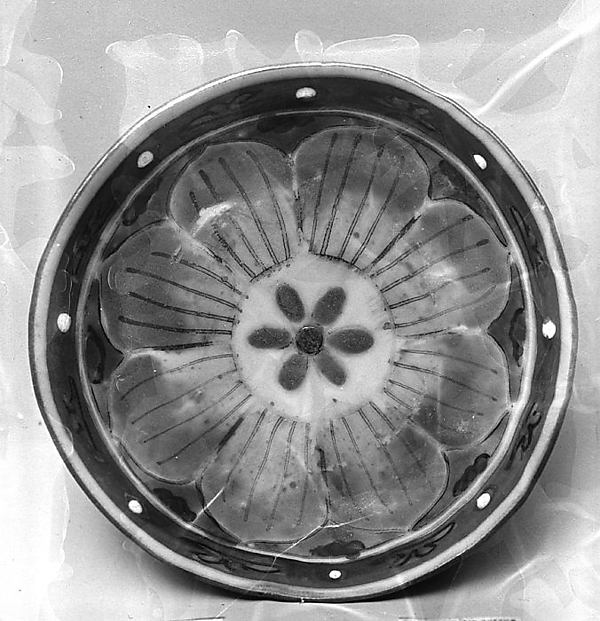

8055
Porcelain with famille verte enamels


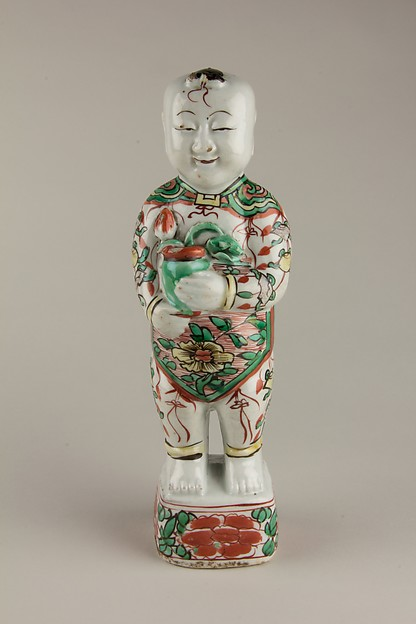

11201
Stoneware with iron-oxide glaze (Jian ware)


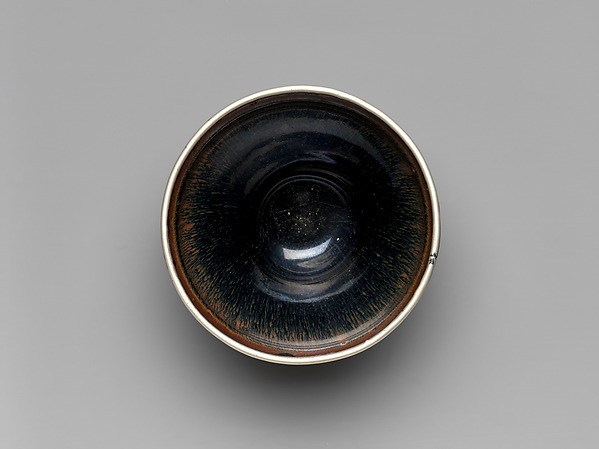

In [27]:
# Let's preview what some non-ivory art pieces look like, to compare
np.random.seed(45)
for index in np.random.choice(non_ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

### Concatenate new dataframes

In [28]:
final_df = pd.concat([new_ivory_df, new_non_ivory_df], ignore_index=True)
print(final_df.shape)
final_df.head()

(3540, 11)


Object_ID                                          Image_URL  \
0     248694  https://images.metmuseum.org/CRDImages/gr/web-...   
1     248695  https://images.metmuseum.org/CRDImages/gr/web-...   
2     257575  https://images.metmuseum.org/CRDImages/gr/web-...   
3      31064  https://images.metmuseum.org/CRDImages/aa/web-...   
4      34077  https://images.metmuseum.org/CRDImages/aa/web-...   

                 Title          Object_Name       Medium  \
0     Relief of a duck     Relief of a duck         Bone   
1    Relief of a child    Relief of a child         Bone   
2           Eye inlays           Eye inlays  Bone, ivory   
3  Sword with Scabbard  Sword with scabbard        Ivory   
4     Hilt of a Dagger     Hilt of a dagger        Ivory   

              Classification           Department                   Culture  \
0  Miscellaneous-Bone, Ivory  Greek and Roman Art                     Roman   
1  Miscellaneous-Bone, Ivory  Greek and Roman Art                       NaN   
2  Miscellaneous-Bone, Ivory  Greek and Roman Art                       NaN   
3                     Swords       Arms and Armor                     Batak   
4                    Daggers       Arms and Armor  possibly Italian, Venice   

           Period        Object_Date  Target  
0  Early Imperial   1st century A.D.       1  
1             NaN                NaN       1  
2             NaN                NaN       1  
3             NaN  16th–19th century       1  
4             NaN           ca. 1300       1

<br>

# Saving Images, File Management, and Train/Validation/Test Split

### Save images to data folder

In [29]:
ivory_indexes = final_df.loc[final_df['Target'] == 1].index
non_ivory_indexes = final_df.loc[final_df['Target'] == 0].index

# Sanity check
ivory_indexes.shape[0] + non_ivory_indexes.shape[0] == final_df.shape[0]

True

In [30]:
ivory_dir_len = len([name for name in os.listdir('data/images/ivory') if not name.endswith('checkpoints')])

# Index filled in from previous run of API call
unidentified_ivory_images = [924]

if ivory_dir_len == 0:
    for index in ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/ivory/ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_ivory_images.append(index)
        
unidentified_ivory_images

[924]

In [31]:
non_ivory_dir_len = len([name for name in os.listdir('data/images/non_ivory') if not name.endswith('checkpoints')])

# Indexes filled in from previous run of API call
unidentified_non_ivory_images = [1996, 2233, 2288]

if non_ivory_dir_len == 0:
    for index in non_ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/non_ivory/non_ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_non_ivory_images.append(index)
            
unidentified_non_ivory_images

[1996, 2233, 2288]

### Drop rows with invalid image URLs

In [32]:
final_df = final_df.drop(unidentified_ivory_images)
final_df = final_df.drop(unidentified_non_ivory_images)

# Reset indexes
final_df.index = range(len(final_df))

print(f"Total items in dataset: {final_df.shape[0]}")
final_df.Target.value_counts()

Total items in dataset: 3536


1    1769
0    1767
Name: Target, dtype: int64

### Save dataframe as .csv file

In [33]:
if os.path.isfile('data/final_df.csv') == False:
    final_df.to_csv('data/final_df.csv')
else:
    final_df = pd.read_csv('data/final_df.csv', index_col=0)

### Create train, validation, and test splits of ivory and non-ivory images

In [34]:
data_ivory_dir = 'data/images/ivory/'
data_non_ivory_dir = 'data/images/non_ivory/'
split_dir = 'data/split/'

test_ivory = 'data/split/test/ivory/'
test_non_ivory = 'data/split/test/non_ivory/'

validation_ivory = 'data/split/validation/ivory/'
validation_non_ivory = 'data/split/validation/non_ivory/'

train_ivory = 'data/split/train/ivory/'
train_non_ivory = 'data/split/train/non_ivory/'

In [35]:
imgs_ivory = [file for file in os.listdir(data_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_ivory)

print('There are', len(imgs_ivory), 'ivory images')
imgs_ivory[:3]

There are 1769 ivory images


['ivory_11946.jpg', 'ivory_31546.jpg', 'ivory_209526.jpg']

In [36]:
imgs_non_ivory = [file for file in os.listdir(data_non_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_non_ivory)

print('There are', len(imgs_non_ivory), 'non-ivory images')
imgs_non_ivory[:3]

There are 1767 non-ivory images


['non_ivory_196599.jpg', 'non_ivory_168773.jpg', 'non_ivory_202636.jpg']

In [37]:
# We'll do an 80/20 train/test split; of the training data, we'll do another 80/20 train/validation split

print(f"Ivory test images slice:        {int(1769*0.8)+1}:1769  --> {int(1769*0.2)} images")
print(f"Ivory validation images slice:  {int(1415*0.8)+1}:{int(1769*0.8)+1}  --> {int(1415*0.2)} images")
print(f"Ivory train images slice:       0:{int(1415*0.8)+1}     --> {int(1415*0.8)+1} images")

Ivory test images slice:        1416:1769  --> 353 images
Ivory validation images slice:  1133:1416  --> 283 images
Ivory train images slice:       0:1133     --> 1133 images


In [38]:
# Repeat for non-ivory images

print(f"Non-ivory test images slice:        {int(1767*0.8)+1}:1767  --> {int(1767*0.2)} images")
print(f"Non-ivory validation images slice:  {int(1414*0.8)+1}:{int(1767*0.8)+1}  --> {int(1414*0.2)} images")
print(f"Non-ivory train images slice:       0:{int(1414*0.8)+1}     --> {int(1414*0.8)+1} images")

Non-ivory test images slice:        1414:1767  --> 353 images
Non-ivory validation images slice:  1132:1414  --> 282 images
Non-ivory train images slice:       0:1132     --> 1132 images


In [39]:
# Test ivory images
imgs = imgs_ivory[1416:1769]
dir_length = len([name for name in os.listdir('data/split/test/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(test_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation ivory images
imgs = imgs_ivory[1133:1416]
dir_length = len([name for name in os.listdir('data/split/validation/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(validation_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train ivory images
imgs = imgs_ivory[0:1133]
dir_length = len([name for name in os.listdir('data/split/train/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(train_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_ivory)), 'ivory images in the test set')
print('There are', len(os.listdir(validation_ivory)), 'ivory images in the validation set')
print('There are', len(os.listdir(train_ivory)), 'ivory images in the train set')

There are 353 ivory images in the test set
There are 283 ivory images in the validation set
There are 1133 ivory images in the train set


In [40]:
# Test non-ivory images
imgs = imgs_non_ivory[1414:1767]
dir_length = len([name for name in os.listdir('data/split/test/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(test_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation non-ivory images
imgs = imgs_non_ivory[1132:1414]
dir_length = len([name for name in os.listdir('data/split/validation/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(validation_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train non-ivory images
imgs = imgs_non_ivory[0:1132]
dir_length = len([name for name in os.listdir('data/split/train/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(train_non_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_non_ivory)), 'non-ivory images in the test set')
print('There are', len(os.listdir(validation_non_ivory)), 'non-ivory images in the validation set')
print('There are', len(os.listdir(train_non_ivory)), 'non-ivory images in the train set')

There are 353 non-ivory images in the test set
There are 282 non-ivory images in the validation set
There are 1132 non-ivory images in the train set


### Examine image resolutions

In a moment we'll have to select the new target sizes (resolutions) for our images. Below we create a plot of the current resolutions of our images to help us decide.

In [41]:
# Get image resolutions
ivory_imgs_sizes = [img.name for img in Path('data/images/ivory/').iterdir() if img.suffix == ".jpg"]
non_ivory_imgs_sizes = [img.name for img in Path('data/images/non_ivory/').iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in ivory_imgs_sizes: img_meta[str(f)] = imagesize.get('data/images/ivory/'+f)
for f in non_ivory_imgs_sizes: img_meta[str(f)] = imagesize.get('data/images/non_ivory/'+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns')
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total number of images in dataset: {len(img_meta_df)}')
img_meta_df.head()

Total number of images in dataset: 3536


FileName        Size  Width  Height  Aspect Ratio
0   ivory_58504.jpg  (600, 560)    600     560          1.07
1  ivory_209813.jpg  (600, 230)    600     230          2.61
2  ivory_209807.jpg  (145, 621)    145     621          0.23
3  ivory_121855.jpg  (599, 411)    599     411          1.46
4  ivory_545856.jpg  (600, 400)    600     400          1.50

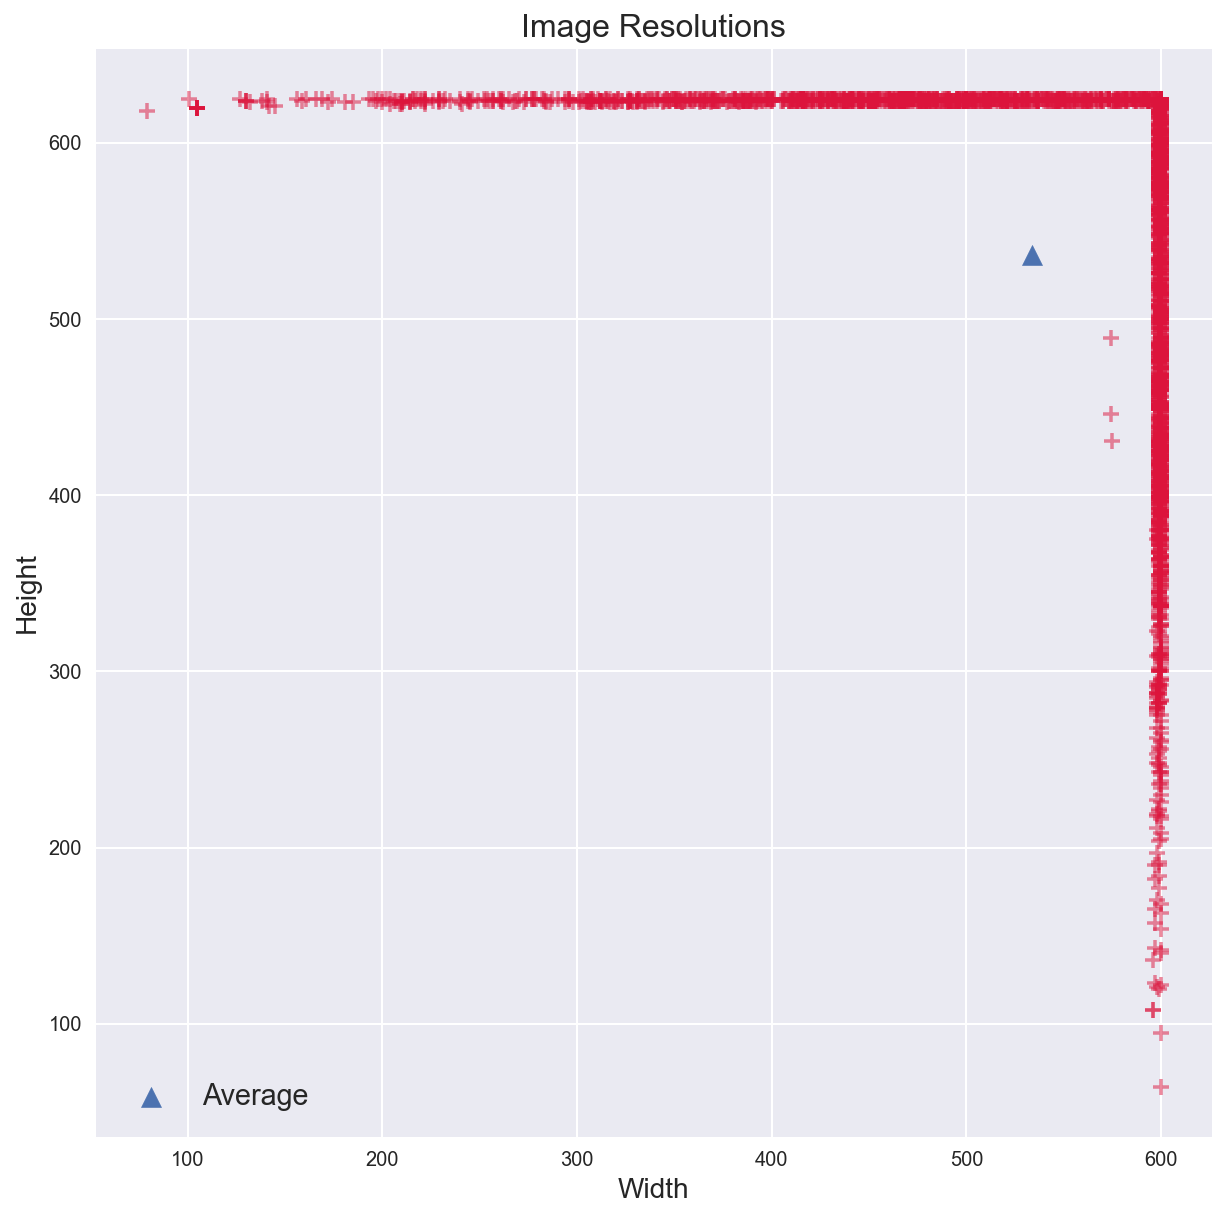

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(img_meta_df.Width, img_meta_df.Height, color='crimson', alpha=0.5, s=60, marker='+')
ax.set_title('Image Resolutions', size=16)
ax.set_xlabel('Width', size=14)
ax.set_ylabel('Height', size=14)
ax.set_xticks(list(range(0, 800, 100)))
ax.set_yticks(list(range(0, 800, 100)))
ax.scatter(x=img_meta_df.Width.mean(), y=img_meta_df.Height.mean(), marker='^', s=100, label='Average')
ax.legend(loc=3, fontsize='x-large');

**Remarks:**
- It looks like all images have either a width or height of around 600, and the average image is around 520x520. A conservative reshaping, without having to upsample too many images, would be 256x256.

### Create ImageDataGenerators for test, validation, and training images

In [43]:
test_folder = os.path.join(split_dir, 'test')
validation_folder = os.path.join(split_dir, 'validation')
train_folder = os.path.join(split_dir, 'train')


# Get all the data in the directory data/split/test (706 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, 
                                                                        classes=['non_ivory', 'ivory'], 
                                                                        target_size=(256, 256), batch_size=706) 

# Get all the data in the directory data/split/validation (565 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_folder, 
                                                                       classes=['non_ivory', 'ivory'], 
                                                                       target_size=(256, 256), batch_size=565)

# Get all the data in the directory data/split/train (2265 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, 
                                                                         classes=['non_ivory', 'ivory'], 
                                                                         target_size=(256, 256), batch_size=2265)

train_generator.class_indices

Found 706 images belonging to 2 classes.
Found 565 images belonging to 2 classes.
Found 2265 images belonging to 2 classes.


{'non_ivory': 0, 'ivory': 1}

In [44]:
# Create the data sets
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)
train_images, train_labels = next(train_generator)

In [45]:
# Explore the dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))

Number of training samples: 2265
Number of testing samples: 706
Number of validation samples: 565
----------------------------------------
test_images shape: (706, 256, 256, 3)
test_labels shape: (706, 2)
----------------------------------------
val_images shape: (565, 256, 256, 3)
val_labels shape: (565, 2)
----------------------------------------
train_images shape: (2265, 256, 256, 3)
train_labels shape: (2265, 2)


In [46]:
# Reshape test, validation, and train images for baseline fully connected (dense) neural network model
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
train_img = train_images.reshape(train_images.shape[0], -1)

test_y = np.reshape(test_labels[:,0], (test_img.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_img.shape[0],1))
train_y = np.reshape(train_labels[:,0], (train_img.shape[0],1))

print("test_img shape: ", str(test_img.shape))
print("val_img shape: ", str(val_img.shape))
print("train_img shape: ", str(train_img.shape))
print('-'*40)
print("test_y shape: ", str(test_y.shape))
print("val_y shape: ", str(val_y.shape))
print("train_y shape: ", str(train_y.shape))

test_img shape:  (706, 196608)
val_img shape:  (565, 196608)
train_img shape:  (2265, 196608)
----------------------------------------
test_y shape:  (706, 1)
val_y shape:  (565, 1)
train_y shape:  (2265, 1)


<br>

# Helper Functions

### Function to plot selection of images and corresponding class labels

In [47]:
def plot_images(images, figsize=(20,4), rows=1, titles=None):
    """
    Takes in image set and image labels and plots a row of the 
    images with associated labels.
    """
    if type(images[0]) is np.ndarray:
        images - np.array(images).astype(np.uint8)
        if (images.shape[-1] != 3):
            images - images.transpose((0,2,3,1))
    fig = plt.figure(figsize=figsize)
    cols = len(images)//rows if len(images) % 2 -- 0 else len(images)//rows + 1
    for i in range(len(images)):
        sp = fig.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            if titles[i][0] == 0.0:
                sp.set_title('Ivory', fontsize=14)
            else:
                sp.set_title('Non-ivory', fontsize=14)
        plt.imshow(images[i])

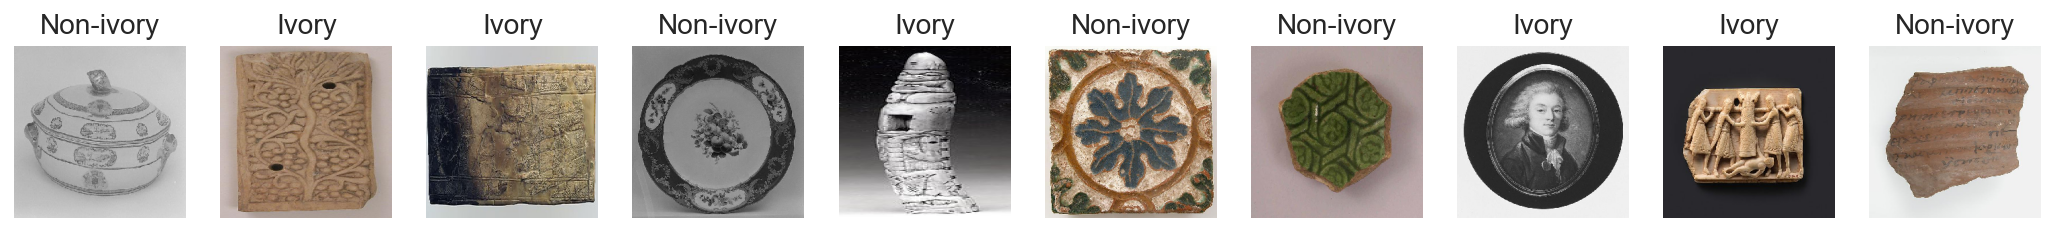

In [48]:
# View 10 items from train_images
plot_images(train_images[42:52], titles=train_labels[42:52])

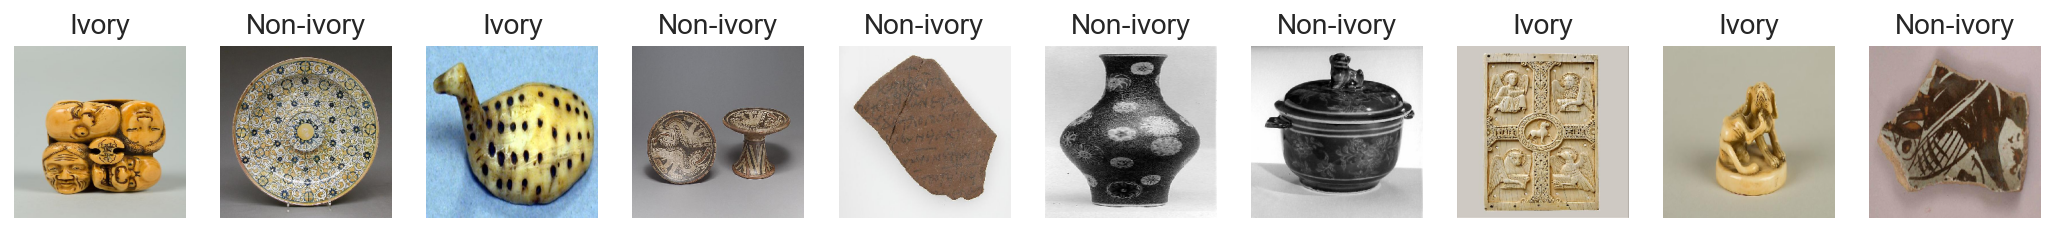

In [49]:
# View 10 items from test_images
plot_images(test_images[42:52], titles=test_labels[42:52])

### Function to display and plot model accuracy and loss scores

In [50]:
def get_model_results(model, model_history):
    """ 
    Takes in a model and model history, and returns the model's 
    loss and accuracy scores. Also returns plots of the training 
    and validation scores across all epochs for accuracy and loss.
    """
    # Return loss and accuracy scores for training and test sets
    if model == baseline_model:
        results_train = model.evaluate(train_img, train_y)
        results_test = model.evaluate(test_img, test_y)
    else:
        results_train = model.evaluate(train_images, train_y)
        results_test = model.evaluate(test_images, test_y)
    
    # Get accuracy and loss for training and validation
    if model == baseline_model:
        acc = model_history.history['accuracy']
        val_acc = model_history.history['val_accuracy']
        loss = model_history.history['loss']
        val_loss = model_history.history['val_loss']
    else:
        acc = model_history.history['acc']
        val_acc = model_history.history['val_acc']
        loss = model_history.history['loss']
        val_loss = model_history.history['val_loss']
    epochs = range(len(acc))
    
    # Return train and test loss and accuracy
    print("-"*40)
    print("Training set loss:", round(results_train[0], 3))
    print("Training set accuracy:", round(results_train[1], 3))
    print("-"*40)
    print("Test set loss:", round(results_test[0], 3))
    print("Test set accuracy:", round(results_test[1], 3))
    
    # Plot the training and validation accuracy and loss
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
    ax1.plot(epochs, acc, label='Training acc')
    ax1.plot(epochs, val_acc, label='Validation acc')
    ax1.set_title('Training and Validation Accuracy', size=12, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Score')
    ax1.legend()
    ax2.plot(epochs, loss, label='Training loss')
    ax2.plot(epochs, val_loss, label='Validation loss')
    ax2.set_title('Training and Validation Loss', size=12, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Score')
    ax2.legend()

### Function to plot confusion matrix

In [51]:
def get_confusion_matrix(model):
    if model == baseline_model:
        y_proba = model.predict(test_img)
    else:
        y_proba = model.predict(test_images)
        
    predicted = y_proba.round()
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(16, 7))
    
    cm = confusion_matrix(test_y, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0: Non-ivory', '1: Ivory'])
    disp.plot(cmap='Reds', ax=ax)
    ax.set_title('Confusion Matrix', size=14, fontweight='bold')
    ax.grid(False)

<br>

# Model 0: Baseline Model, Fully Connected Neural Network

In [52]:
# Build a fully connected baseline model
baseline_model = Sequential([
    Dense(64, activation='relu', input_shape=(train_img.shape[1],)),
    Dense(32, activation='relu'),  # 1 hidden layer
    Dense(1, activation='sigmoid')
])

baseline_model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                12582976  
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,585,089
Trainable params: 12,585,089
Non-trainable params: 0
_________________________________________________________________


2022-08-03 18:00:51.268832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 18:00:51.268969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [53]:
baseline_model.compile(optimizer='sgd', 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Terminate training if no improvement by specified min_delta on validation accuracy for 5 epochs
early_stopping = [EarlyStopping(monitor='val_accuracy', 
                                min_delta=0.01, 
                                patience=5),
                  ModelCheckpoint(filepath='data/models/baseline_model.h5',  # Save best model scored by val_acc
                                  verbose=1, 
                                  monitor='val_accuracy', 
                                  save_best_only=True)]

if os.path.isfile('data/models/baseline_model_history.pkl') == False:
    baseline_model_history = baseline_model.fit(train_img, 
                                            train_y, 
                                            epochs=30, 
                                            batch_size=32, 
                                            validation_data=(val_img, val_y), 
                                            callbacks=[early_stopping])

In [54]:
# Save model history as pickle object, or open saved model history if object has already been saved
baseline_model = load_model('data/models/baseline_model.h5')

if os.path.isfile('data/models/baseline_model_history.pkl') == False:
    with open('data/models/baseline_model_history.pkl', 'wb') as f:
        joblib.dump(baseline_model_history, f)
else:
    with open('data/models/baseline_model_history.pkl', 'rb') as f:
        baseline_model_history = joblib.load(f)

2022-08-03 18:00:52.752876: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-03 18:00:52.845180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 2s 78ms/step - loss: 0.6285 - accuracy: 0.7195
----------------------------------------
Training set loss: 0.617
Training set accuracy: 0.73
----------------------------------------
Test set loss: 0.629
Test set accuracy: 0.72


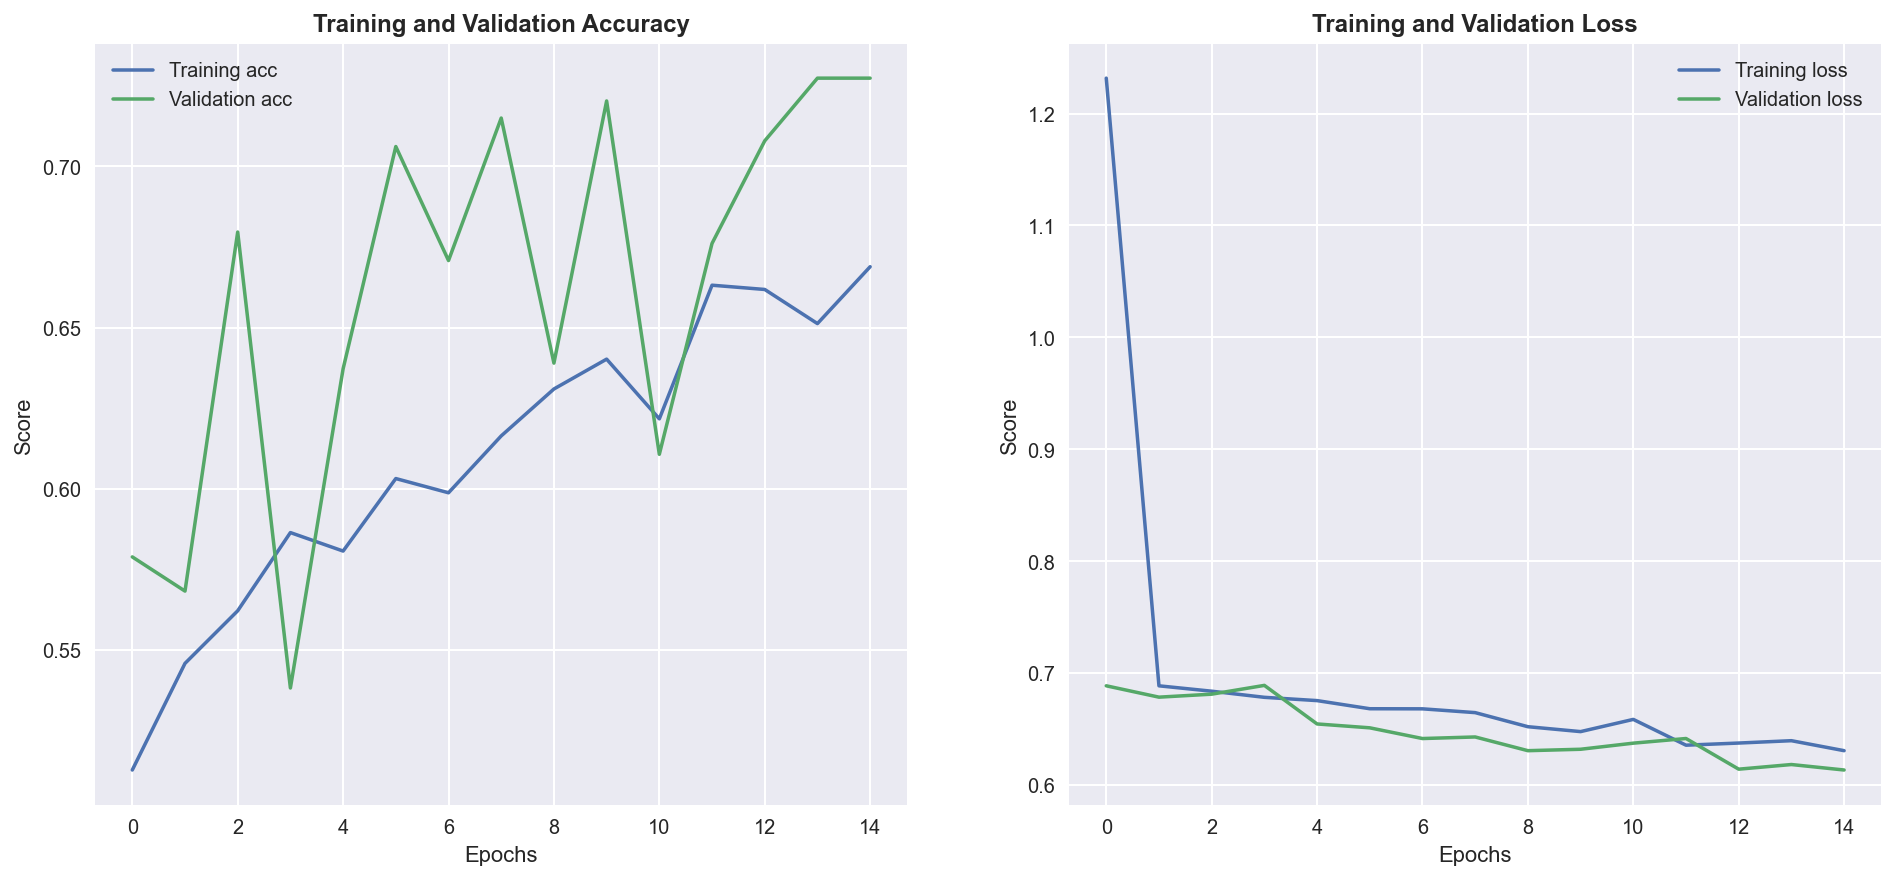

In [55]:
get_model_results(baseline_model, baseline_model_history)

 2/23 [=>............................] - ETA: 1s

2022-08-03 18:01:01.275791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 2s 76ms/step


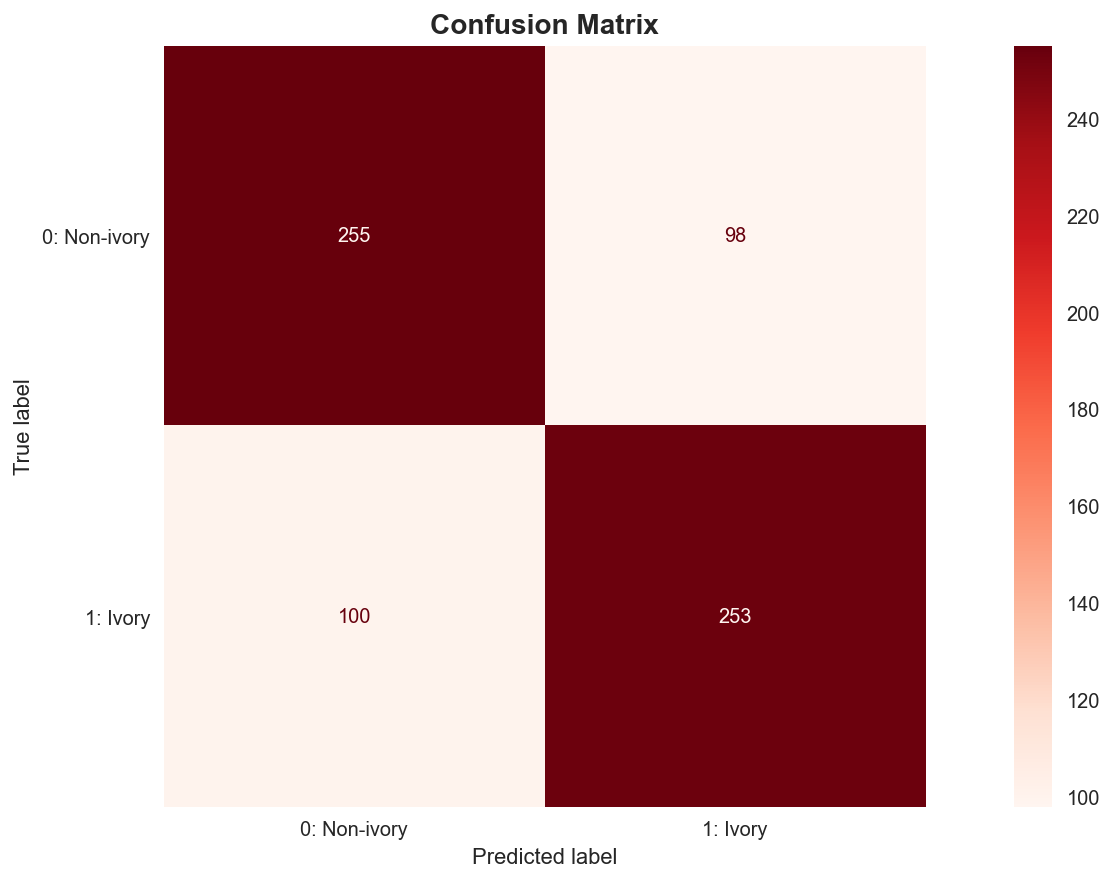

In [56]:
get_confusion_matrix(baseline_model)

**Remarks:**
 - Remarks here

<br>

# Model 1: CNN, Iteration 1

In [57]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (4, 4), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)      

In [58]:
model_1.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['acc'])

# Terminate training if no improvement by specified min_delta on validation accuracy for 10 epochs
early_stopping = [EarlyStopping(monitor='val_acc', 
                                min_delta=0.005, 
                                patience=10),
                  ModelCheckpoint(filepath='data/models/model_1.h5',  # Save best model scored by val_acc
                                  verbose=1, 
                                  monitor='val_acc', 
                                  save_best_only=True)]

if os.path.isfile('data/models/model_1_history.pkl') == False:
    model_1_history = model_1.fit(train_images, 
                                  train_y, 
                                  epochs=30, 
                                  batch_size=32, 
                                  validation_data=(val_images, val_y), 
                                  callbacks=[early_stopping])

In [59]:
# Save model history as pickle object, or open saved model history if object has already been saved
model_1 = load_model('data/models/model_1.h5')

if os.path.isfile('data/models/model_1_history.pkl') == False:
    with open('data/models/model_1_history.pkl', 'wb') as f:
        joblib.dump(model_1_history, f)
else:
    with open('data/models/model_1_history.pkl', 'rb') as f:
        model_1_history = joblib.load(f)

2022-08-03 18:01:04.493259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 38ms/step - loss: 0.4440 - acc: 0.8244
----------------------------------------
Training set loss: 0.324
Training set accuracy: 0.868
----------------------------------------
Test set loss: 0.444
Test set accuracy: 0.824


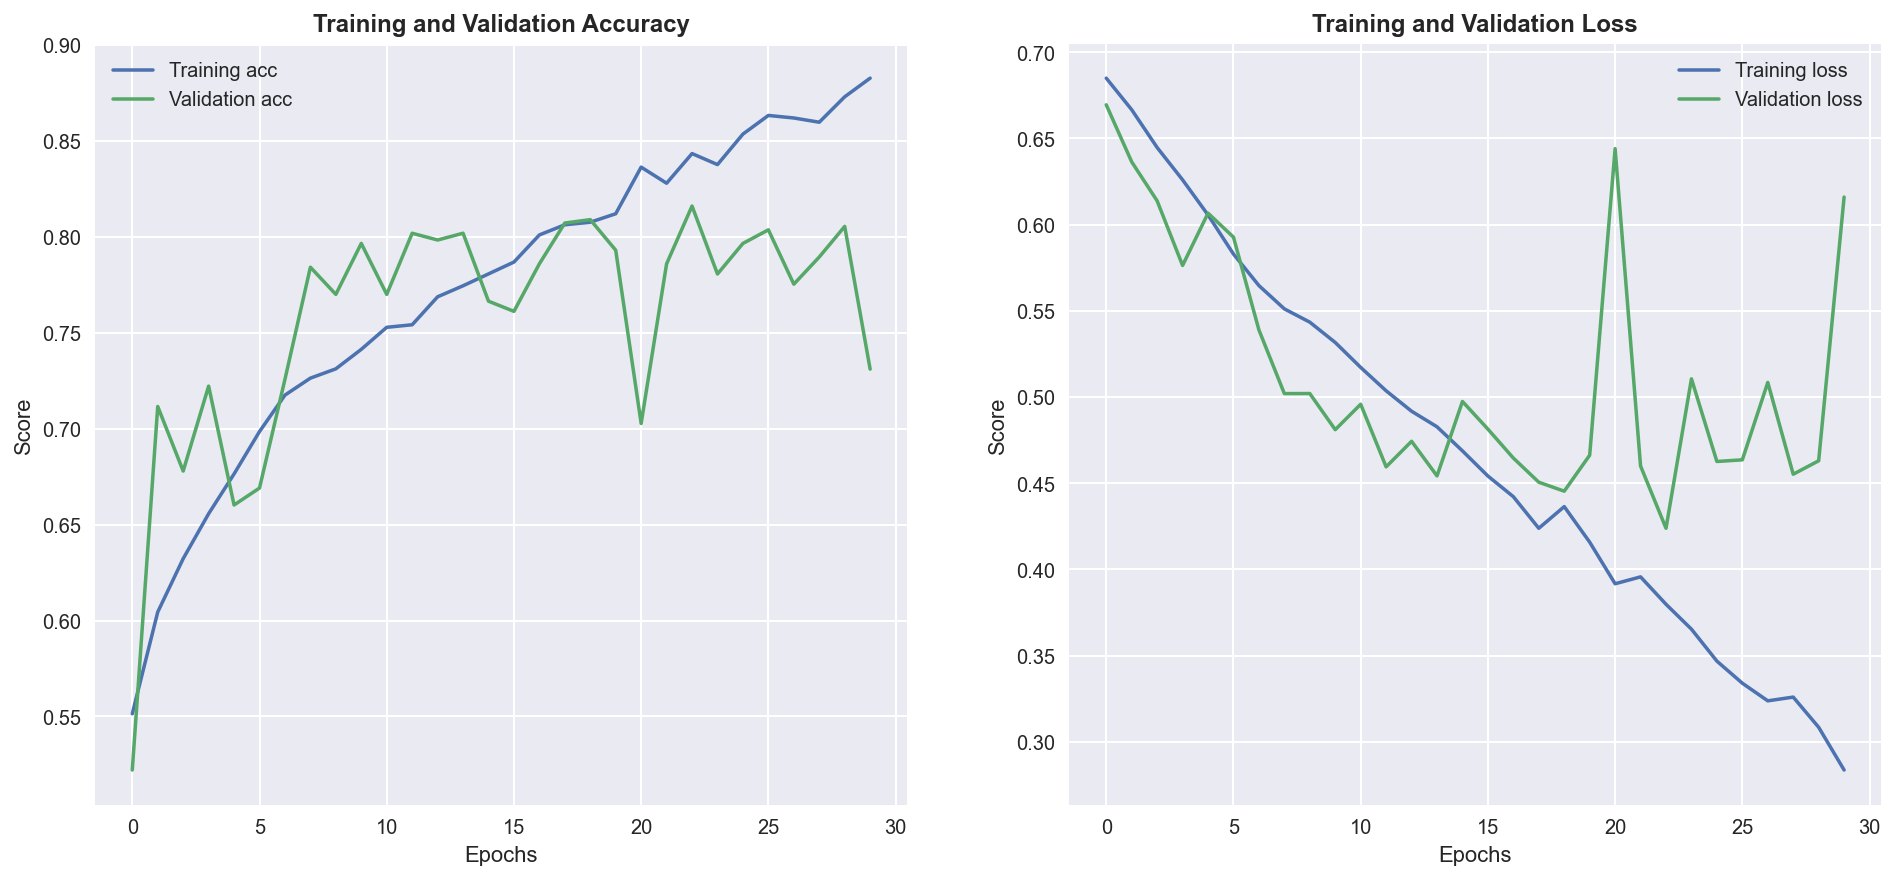

In [60]:
get_model_results(model_1, model_1_history)

 5/23 [=====>........................] - ETA: 0s

2022-08-03 18:01:09.709444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 34ms/step


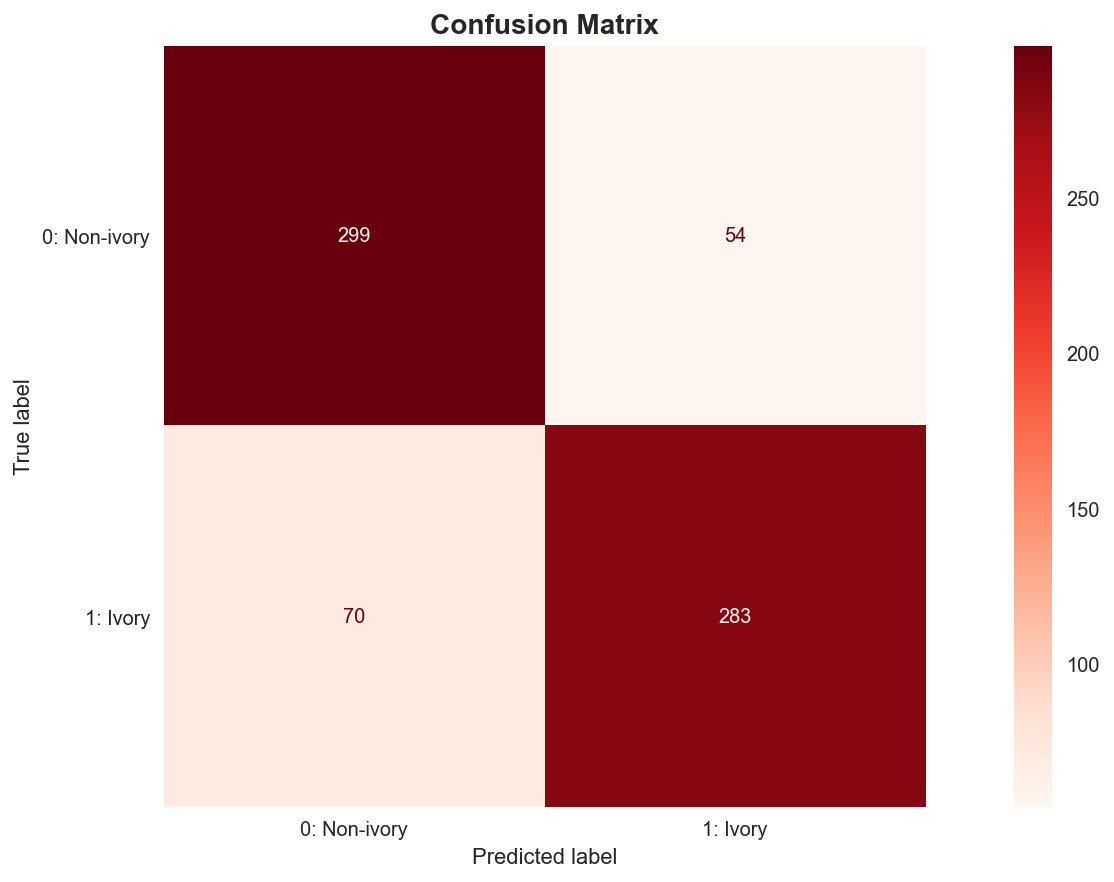

In [61]:
get_confusion_matrix(model_1)

**Remarks:**
- Remarks here

<br>

# Model 2: CNN, Iteration 2 - Adaptive Moment Estimation Optimization

In [62]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)), 
    MaxPooling2D((2, 2)),

    Conv2D(32, (4, 4), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      16416     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)      

In [63]:
model_2.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['acc'])

# Terminate training if no improvement by specified min_delta on train accuracy for 10 epochs
early_stopping = [EarlyStopping(monitor='val_acc', 
                                min_delta=0.005, 
                                patience=10),
                  ModelCheckpoint(filepath='data/models/model_2.h5',  # Save best model scored by val_acc
                                  verbose=1, 
                                  monitor='val_acc', 
                                  save_best_only=True)]

if os.path.isfile('data/models/model_2_history.pkl') == False:
    model_2_history = model_2.fit(train_images, 
                                  train_y, 
                                  epochs=30, 
                                  batch_size=32, 
                                  validation_data=(val_images, val_y), 
                                  callbacks=[early_stopping])

In [64]:
# Save model history as pickle object, or open saved model history if object has already been saved
model_2 = load_model('data/models/model_2.h5')

if os.path.isfile('data/models/model_2_history.pkl') == False:
    with open('data/models/model_2_history.pkl', 'wb') as f:
        joblib.dump(model_2_history, f)
else:
    with open('data/models/model_2_history.pkl', 'rb') as f:
        model_2_history = joblib.load(f)

2022-08-03 18:01:12.186102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 36ms/step - loss: 1.0004 - acc: 0.8201
----------------------------------------
Training set loss: 0.019
Training set accuracy: 0.997
----------------------------------------
Test set loss: 1.0
Test set accuracy: 0.82


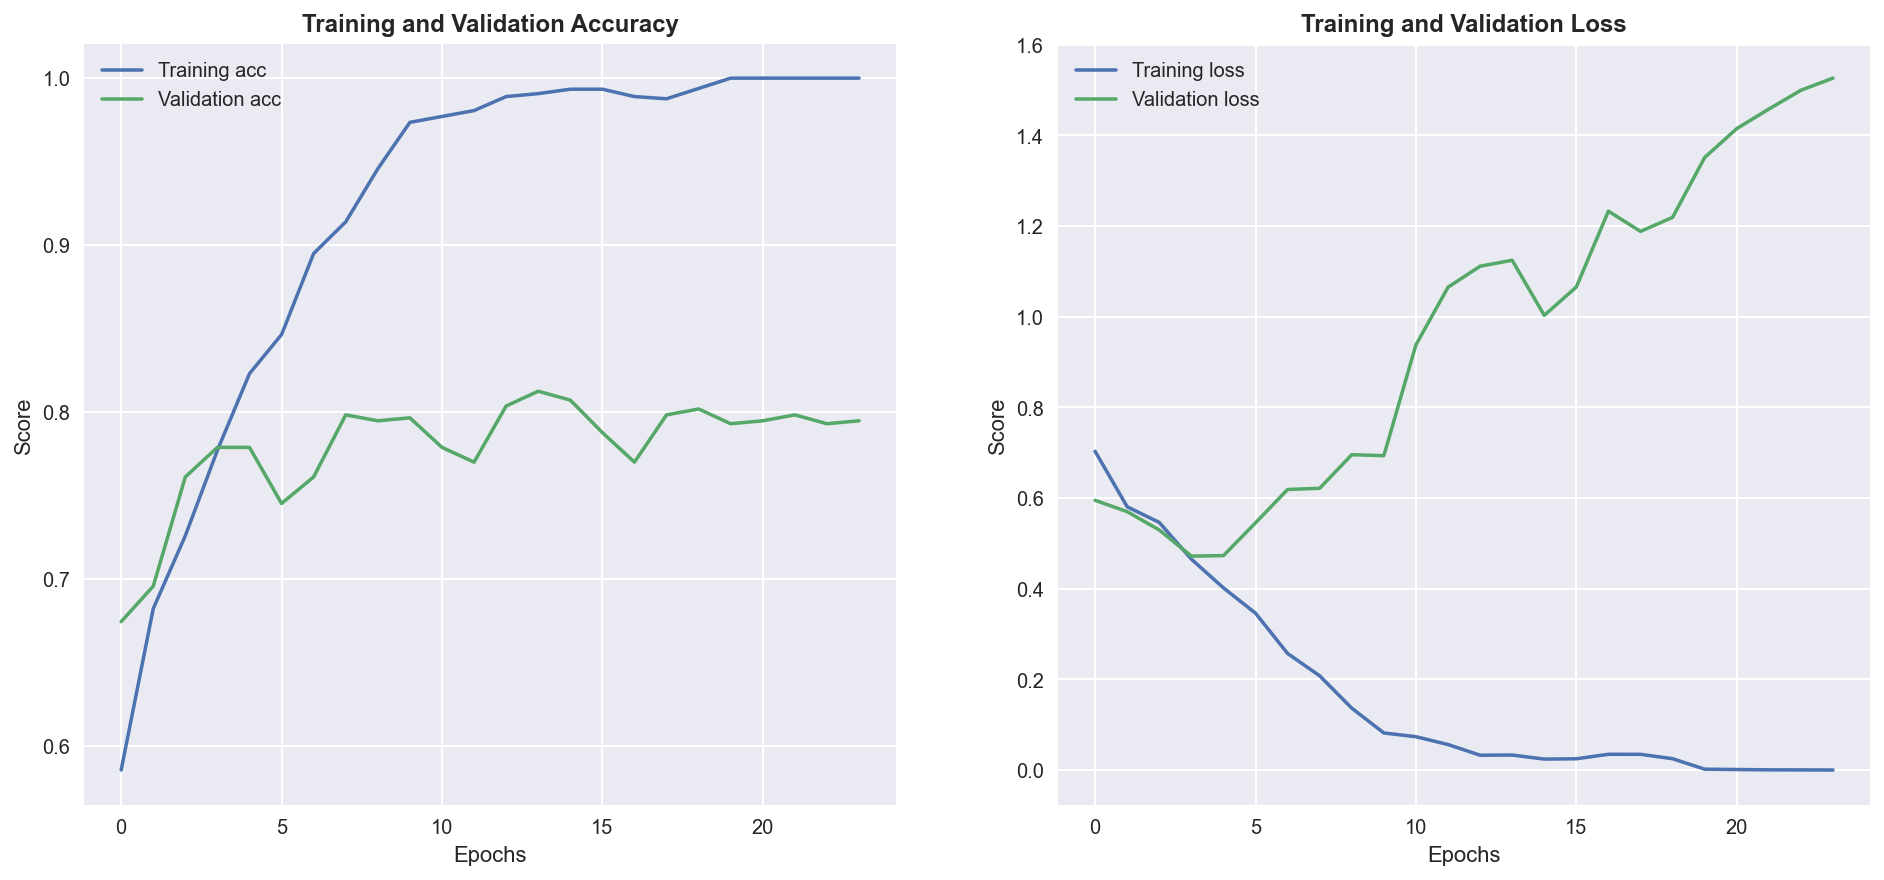

In [65]:
get_model_results(model_2, model_2_history)

 5/23 [=====>........................] - ETA: 0s

2022-08-03 18:01:17.169031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 34ms/step


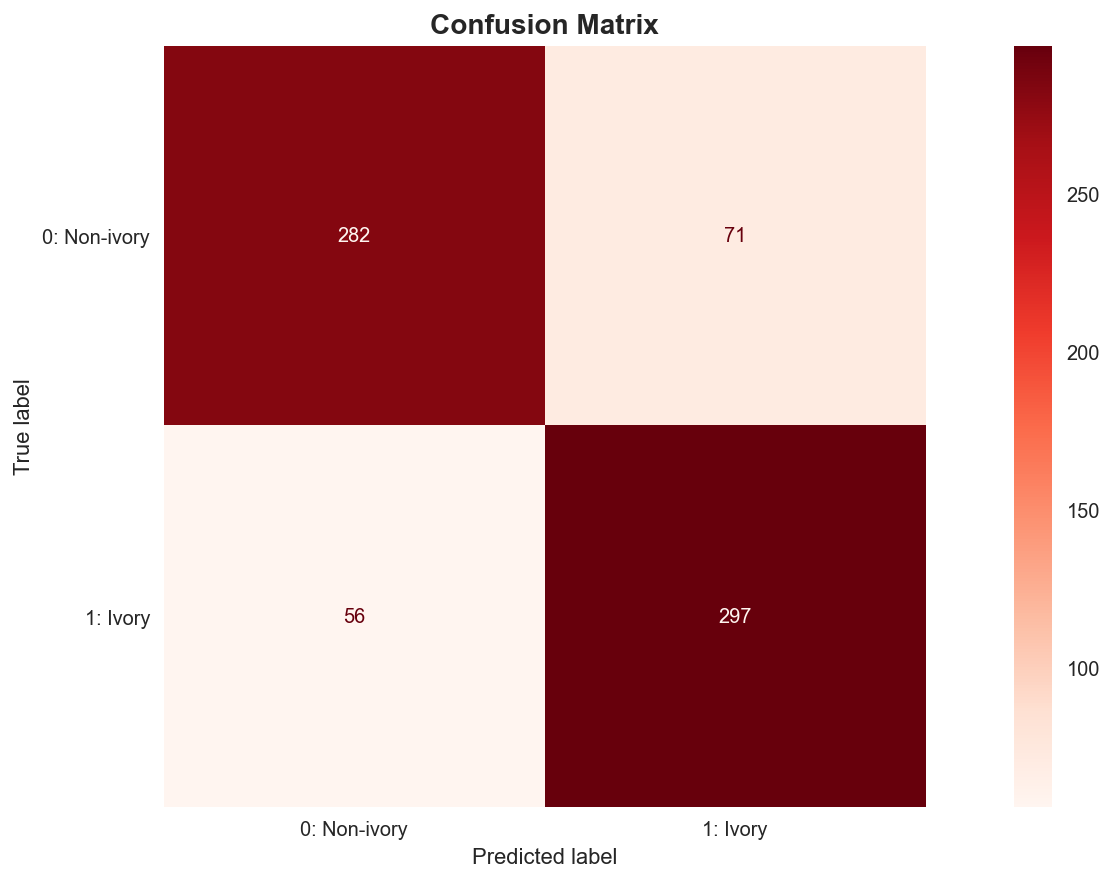

In [66]:
get_confusion_matrix(model_2)

**Remarks:**
- Remarks here
- It also looks like with adam optimization, the model is converging quicker

<br>

# Model 3, CNN Iteration 3 - L2 Regularization

In [67]:
model_3 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (4, 4), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      16416     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)      

In [68]:
model_3.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['acc'])

early_stopping = [EarlyStopping(monitor='val_acc', 
                                min_delta=0.005, 
                                patience=10),
                  ModelCheckpoint(filepath='data/models/model_3.h5', 
                                  verbose=1, 
                                  monitor='val_acc', 
                                  save_best_only=True)]

if os.path.isfile('data/models/model_3.h5') == False:
    model_3_history = model_3.fit(train_images, 
                                  train_y, 
                                  epochs=30, 
                                  batch_size=32, 
                                  validation_data=(val_images, val_y), 
                                  callbacks=[early_stopping])

In [69]:
model_3 = load_model('data/models/model_3.h5')

if os.path.isfile('data/models/model_3_history.pkl') == False:
    with open('data/models/model_3_history.pkl', 'wb') as f:
        joblib.dump(model_3_history, f)
else:
    with open('data/models/model_3_history.pkl', 'rb') as f:
        model_3_history = joblib.load(f)

 1/71 [..............................] - ETA: 12s - loss: 0.2128 - acc: 0.9688

2022-08-03 18:01:19.157519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 36ms/step - loss: 0.4503 - acc: 0.8229
----------------------------------------
Training set loss: 0.308
Training set accuracy: 0.891
----------------------------------------
Test set loss: 0.45
Test set accuracy: 0.823


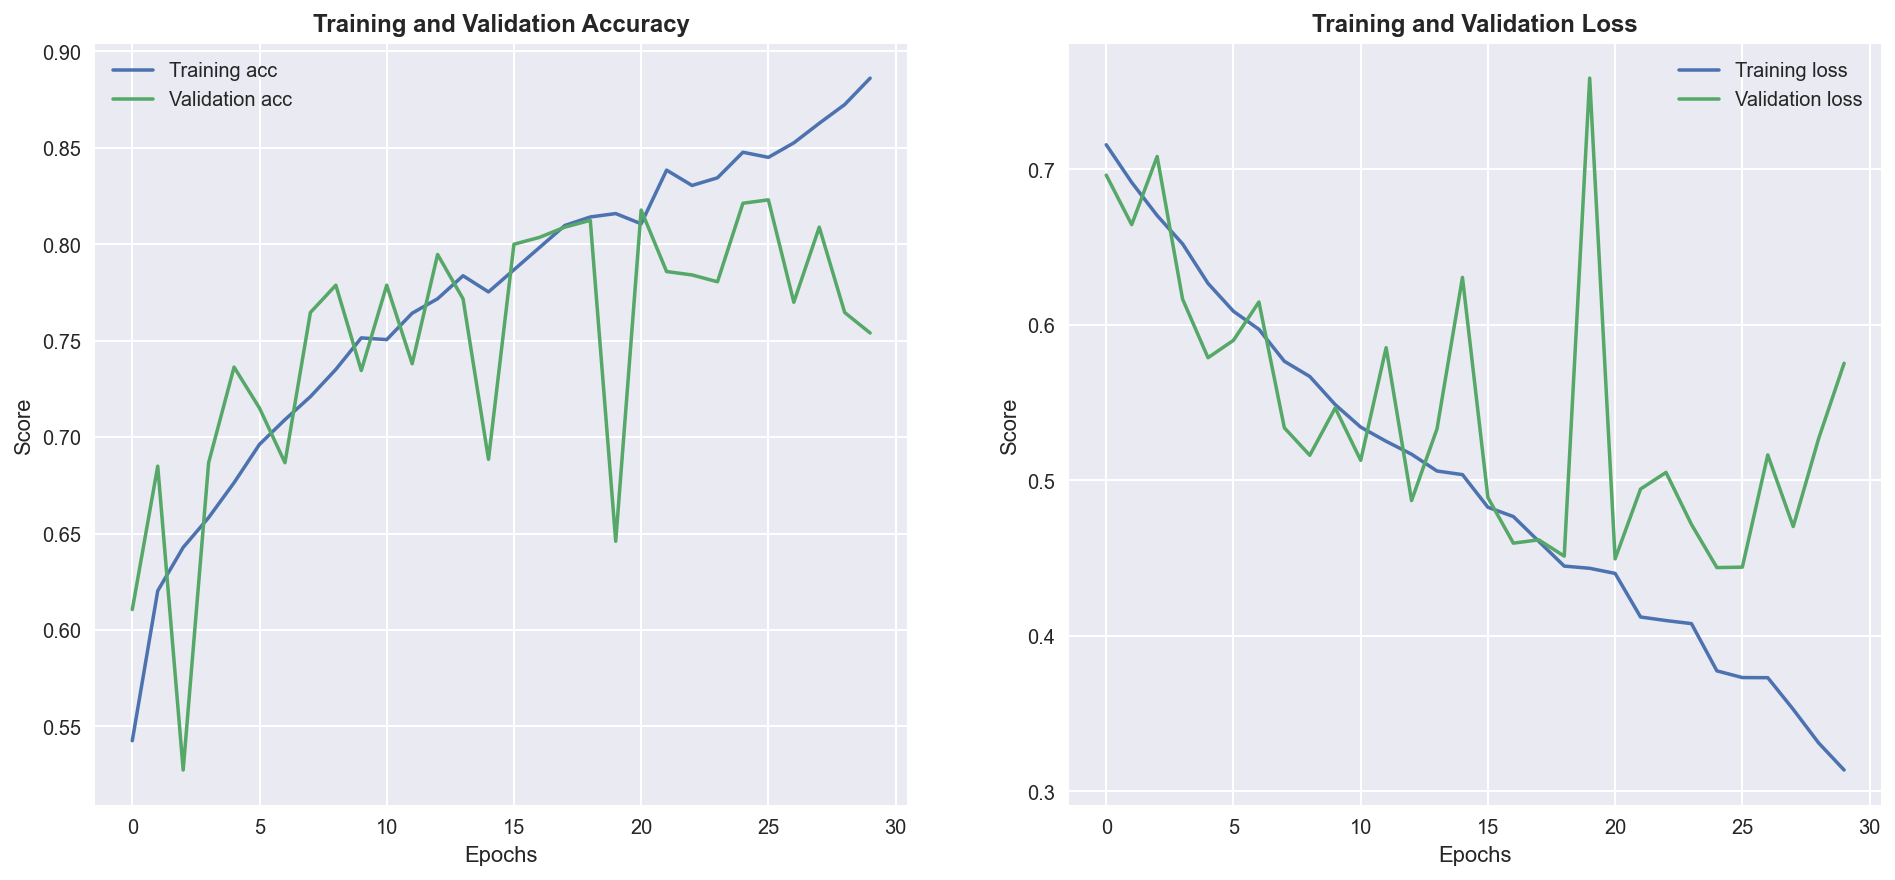

In [70]:
get_model_results(model_3, model_3_history)

 5/23 [=====>........................] - ETA: 0s

2022-08-03 18:01:23.738692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 34ms/step


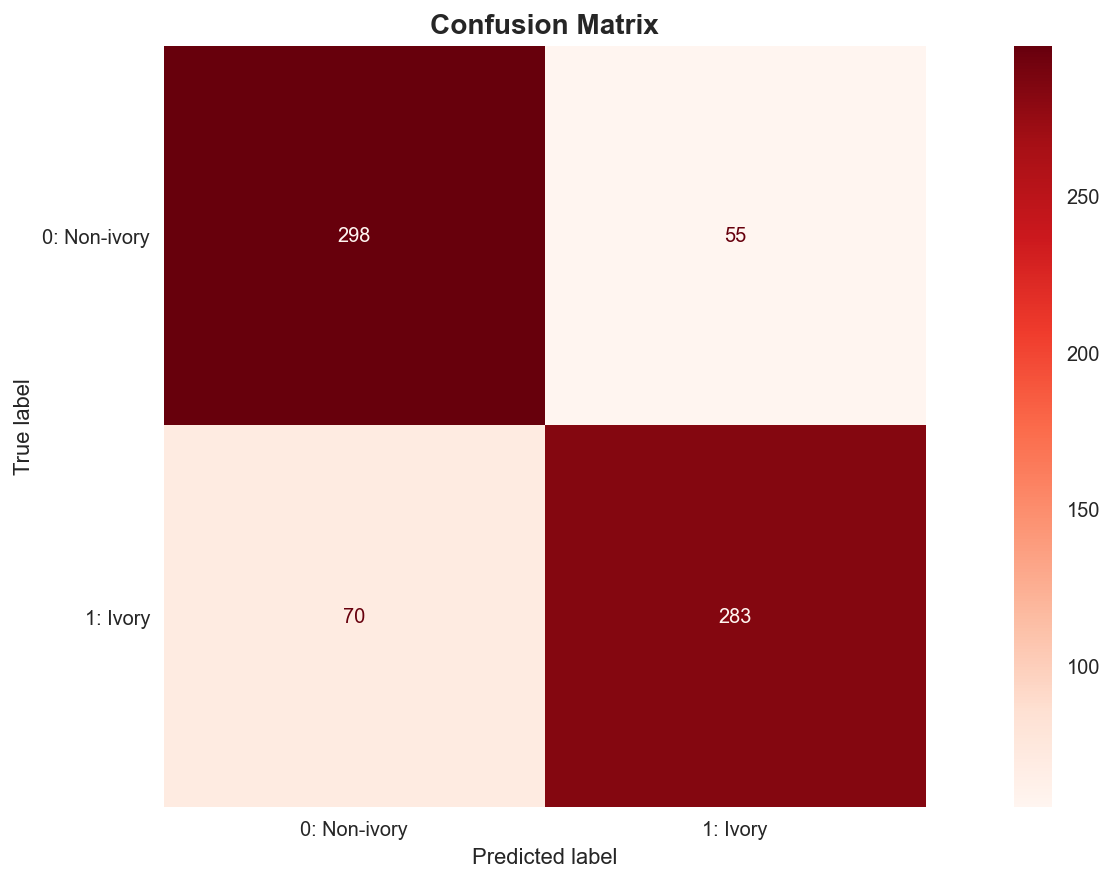

In [71]:
get_confusion_matrix(model_3)

**Remarks:**
- Remarks here

<br>

# Model 4, CNN Iteration 4 - Reduced Batch Size

In [72]:
model_4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'), 
    MaxPooling2D((2, 2)),

    Conv2D(32, (4, 4), activation='relu', padding='same'), 
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'), 
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      16416     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)      

In [73]:
model_4.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['acc'])

# Terminate training if no improvement by specified min_delta on validation accuracy for 10 epochs
early_stopping = [EarlyStopping(monitor='val_acc', 
                                min_delta=0.005, 
                                patience=10),
                  ModelCheckpoint(filepath='data/models/model_4.h5',  # Save best model scored by val_acc
                                  verbose=1, 
                                  monitor='val_acc', 
                                  save_best_only=True)]

if os.path.isfile('data/models/model_4_history.pkl') == False:
    model_4_history = model_4.fit(train_images, 
                                  train_y, 
                                  epochs=30, 
                                  batch_size=16, 
                                  validation_data=(val_images, val_y), 
                                  callbacks=[early_stopping])

In [74]:
model_4 = load_model('data/models/model_4.h5')

if os.path.isfile('data/models/model_4_history.pkl') == False:
    with open('data/models/model_4_history.pkl', 'wb') as f:
        joblib.dump(model_4_history, f)
else:
    with open('data/models/model_4_history.pkl', 'rb') as f:
        model_4_history = joblib.load(f)

2022-08-03 18:01:25.861385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 40ms/step - loss: 0.5096 - acc: 0.8229
----------------------------------------
Training set loss: 0.202
Training set accuracy: 0.919
----------------------------------------
Test set loss: 0.51
Test set accuracy: 0.823


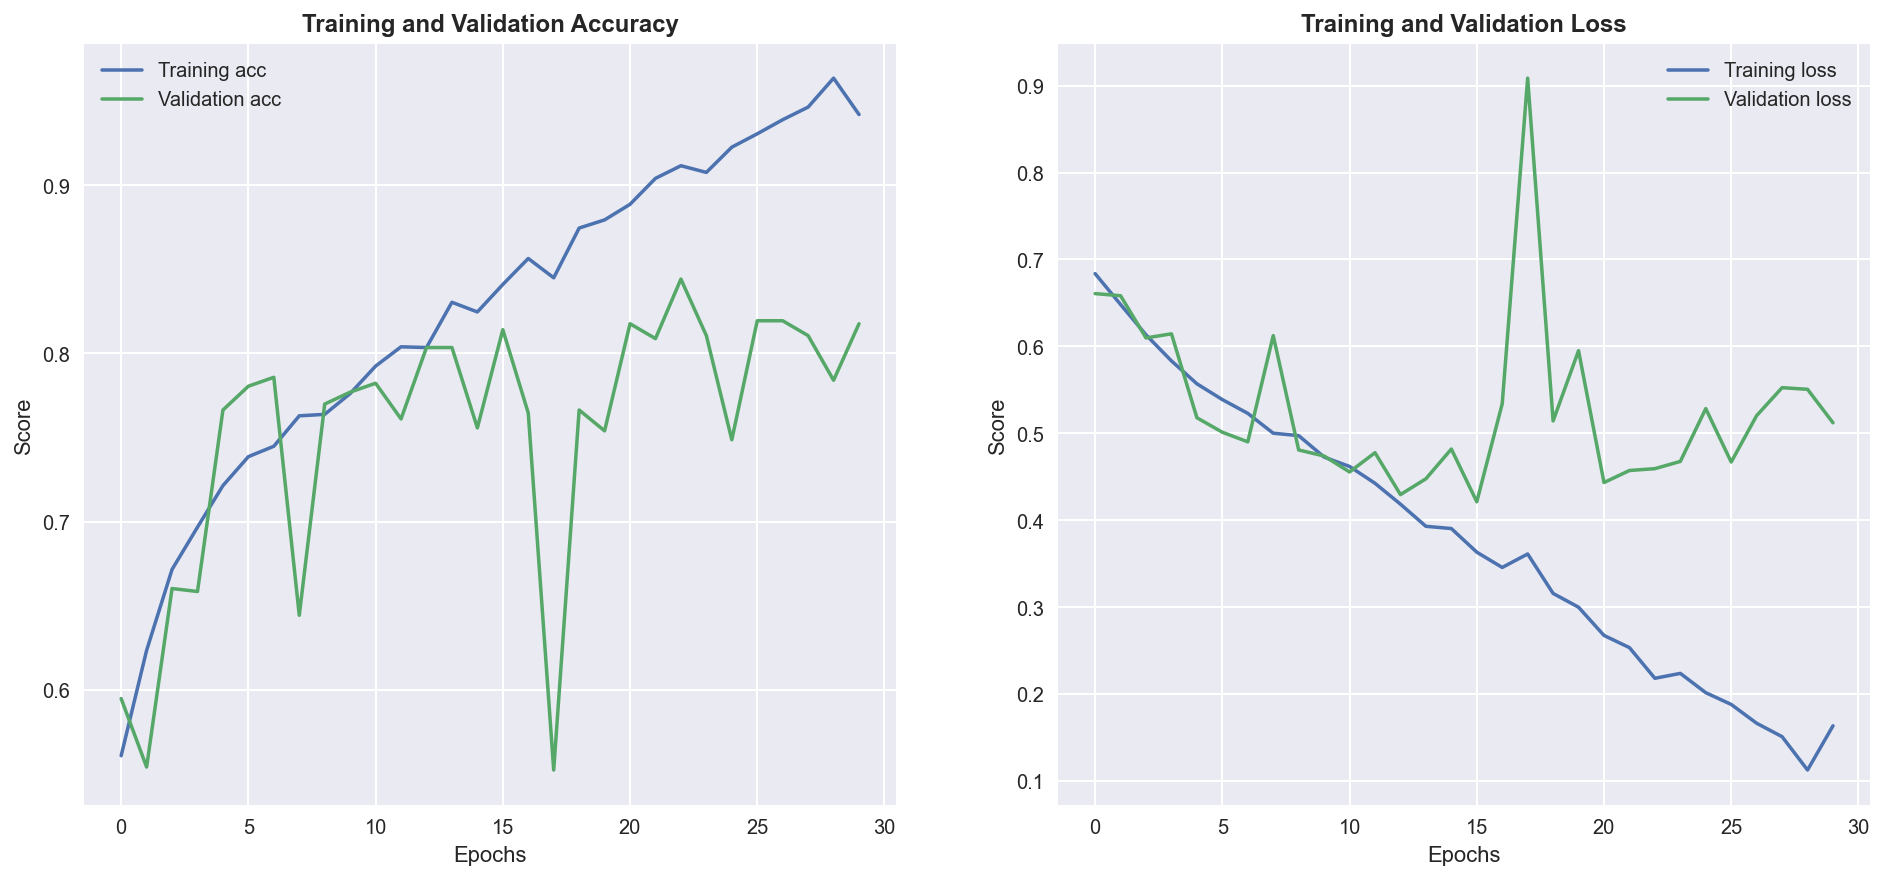

In [75]:
get_model_results(model_4, model_4_history)

 1/23 [>.............................] - ETA: 3s

2022-08-03 18:01:31.032232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 38ms/step


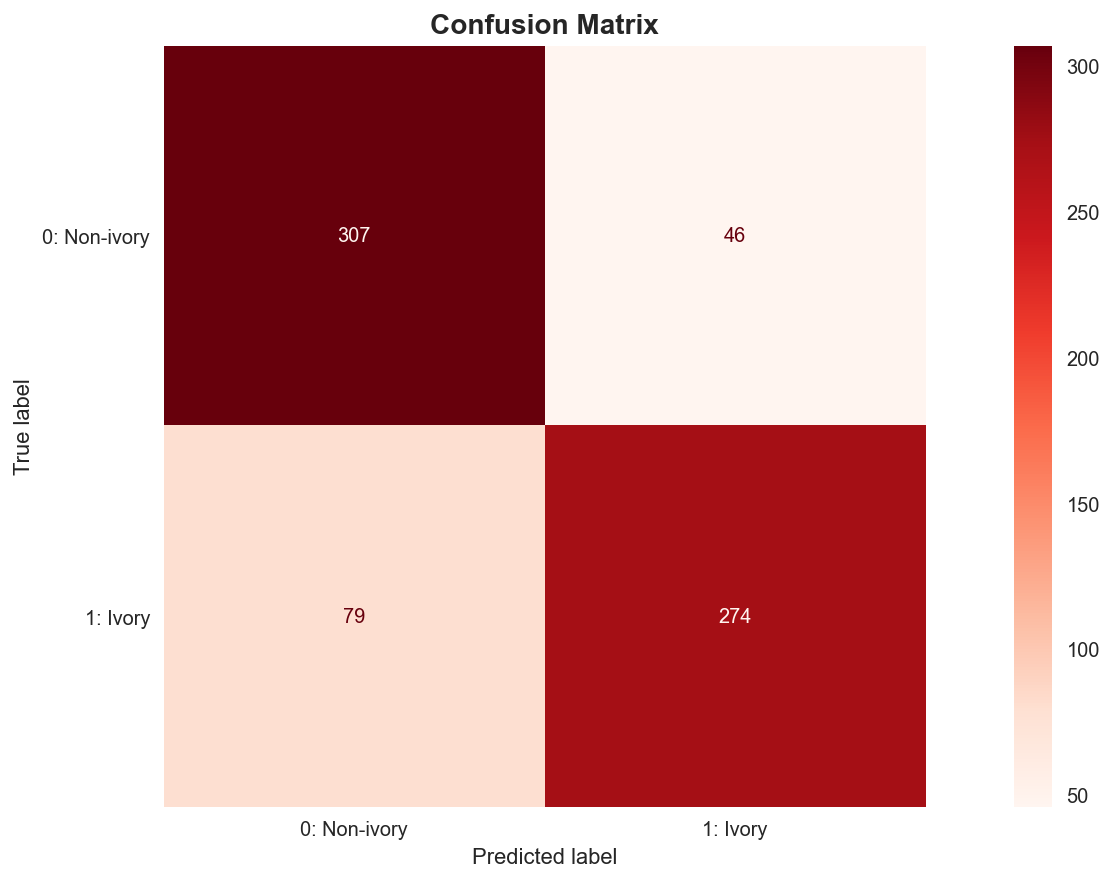

In [76]:
get_confusion_matrix(model_4)

**Remarks:**
- Remarks here

<br>

# Model 5, CNN Iteration 5 - Increased Number of Filters

In [77]:
model_5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (4, 4), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (4, 4), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 64)      32832     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 59, 59, 128)       131200    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 29, 29, 128)     

In [78]:
model_5.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['acc'])

# Terminate training if no improvement by specified min_delta on validation accuracy for 10 epochs
early_stopping = [EarlyStopping(monitor='val_acc', 
                                min_delta=0.005, 
                                patience=10),
                  ModelCheckpoint(filepath='data/models/model_5.h5',  # Save best model scored by val_acc
                                  verbose=1, 
                                  monitor='val_acc', 
                                  save_best_only=True)]

if os.path.isfile('data/models/model_5_history.pkl') == False:
    model_5_history = model_5.fit(train_images, 
                                  train_y, 
                                  epochs=30, 
                                  batch_size=32, 
                                  validation_data=(val_images, val_y), 
                                  callbacks=[early_stopping])

In [79]:
model_5 = load_model('data/models/model_5.h5')

if os.path.isfile('data/models/model_5_history.pkl') == False:
    with open('data/models/model_5_history.pkl', 'wb') as f:
        joblib.dump(model_5_history, f)
else:
    with open('data/models/model_5_history.pkl', 'rb') as f:
        model_5_history = joblib.load(f)

2022-08-03 18:01:33.685371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 2s 71ms/step - loss: 0.4522 - acc: 0.8144
----------------------------------------
Training set loss: 0.359
Training set accuracy: 0.849
----------------------------------------
Test set loss: 0.452
Test set accuracy: 0.814


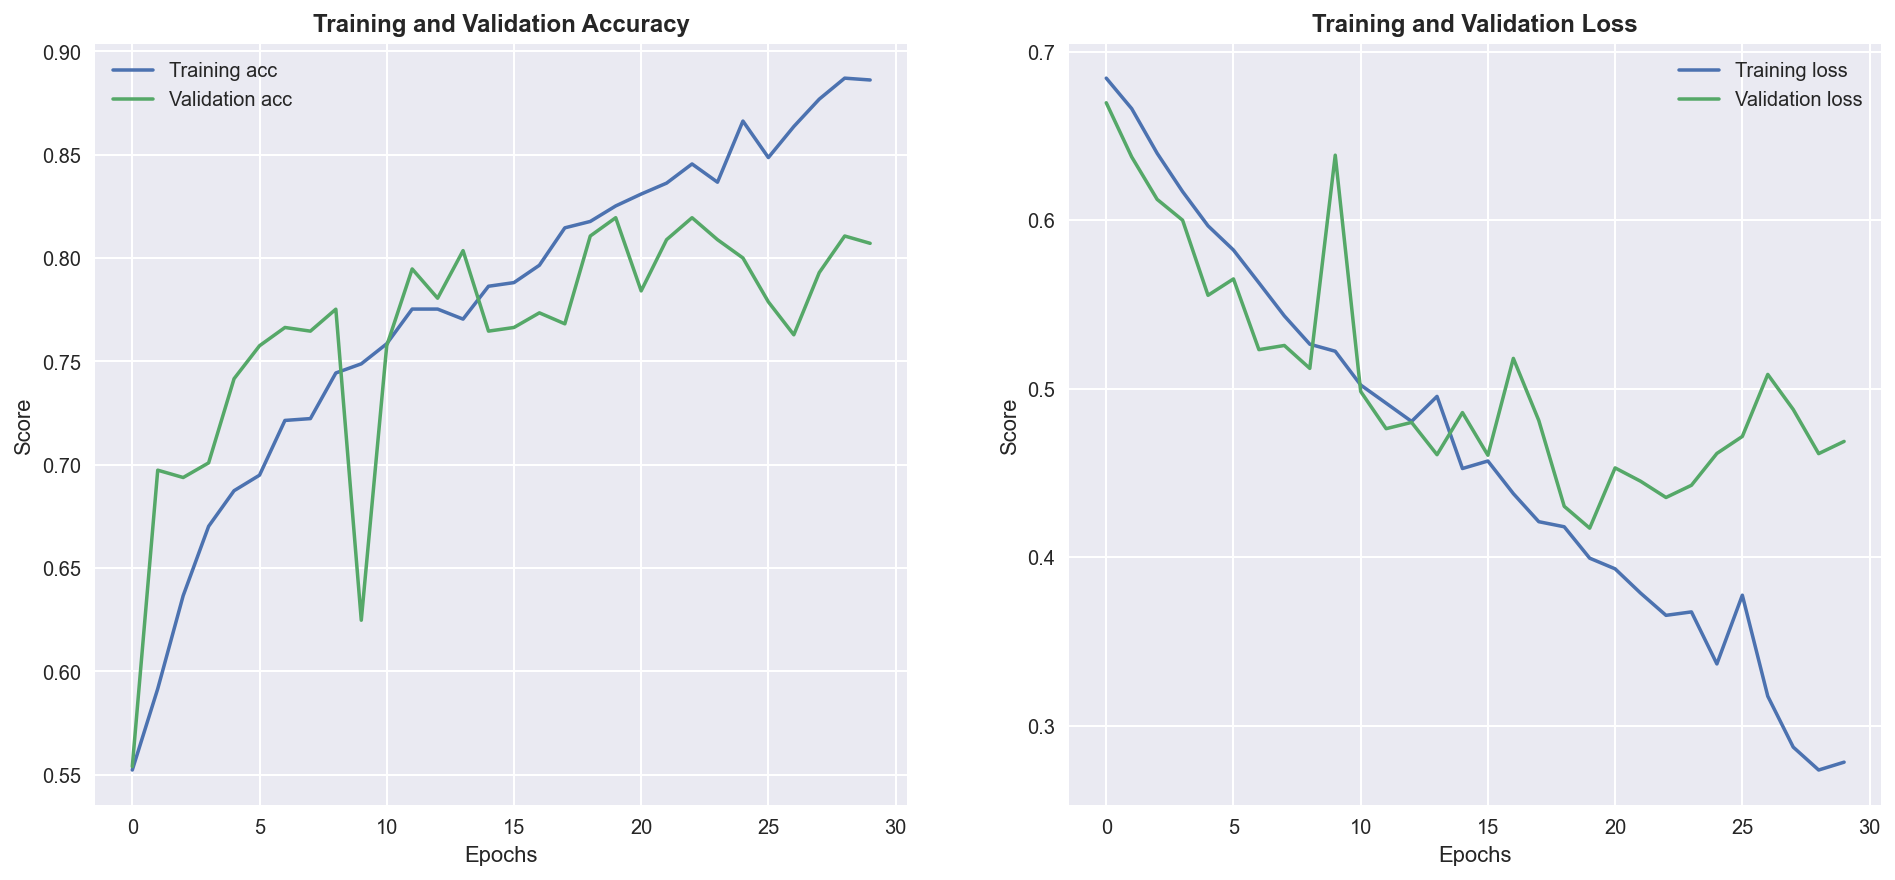

In [80]:
get_model_results(model_5, model_5_history)

 2/23 [=>............................] - ETA: 1s

2022-08-03 18:01:41.874679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 2s 70ms/step


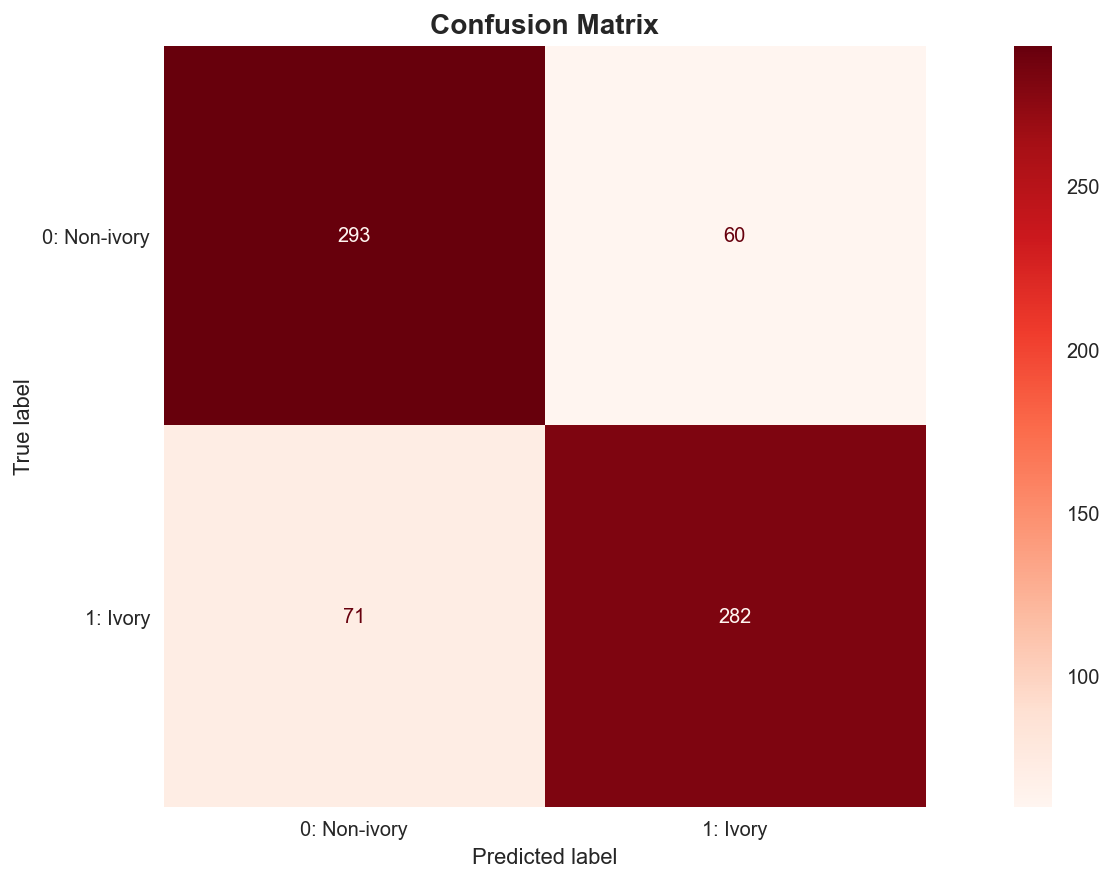

In [81]:
get_confusion_matrix(model_5)

<br>

# Results

## Dataframe of Compiled Model Results

In [82]:
columns = ['Model', 'Training Accuracy', 'Test Accuracy']

models = ['Baseline Model: Fully-Connected (Dense) ANN', 'Model 1: Standard CNN', 
          'Model 2: CNN with Adam Optimizer', 'Model 3: CNN with L2 Regularization', 
          'Model 4: CNN with Reduced Batch Size', 'Model 5: CNN with More Filters']

train_accuracy_scores = [0.730, 0.868, 0.997, 0.891, 0.919, 0.849]
test_accuracy_scores = [0.720, 0.824, 0.820, 0.823, 0.823, 0.814]

compiled_acc_scores = list(zip(models, train_accuracy_scores, test_accuracy_scores))

compiled_acc_scores_df = pd.DataFrame(compiled_acc_scores, columns=columns)
compiled_acc_scores_df.sort_values(by=['Test Accuracy', 'Training Accuracy'], ascending=False)

Model  Training Accuracy  \
1                        Model 1: Standard CNN              0.868   
4         Model 4: CNN with Reduced Batch Size              0.919   
3          Model 3: CNN with L2 Regularization              0.891   
2             Model 2: CNN with Adam Optimizer              0.997   
5               Model 5: CNN with More Filters              0.849   
0  Baseline Model: Fully-Connected (Dense) ANN              0.730   

   Test Accuracy  
1          0.824  
4          0.823  
3          0.823  
2          0.820  
5          0.814  
0          0.720

## Examine Artifact Images of Correct and Incorrect Predictions

In [83]:
# Create list of predictions on test data
test_predictions = model_1.predict(test_images)

# Flatten arrays of predictions (currently in [0. 1.] or [1. 0.] form)
test_labels_flattened = []

for label in test_labels:
    if label[0] == 0:
        test_labels_flattened.append(0)
    else:
        test_labels_flattened.append(1)
        
# Round arrays of predictions (currently floats ranging from 0.0 to 1.0)
test_predictions_rounded = []

for pred in test_predictions:
    if pred < 0.5:
        test_predictions_rounded.append(0)
    else:
        test_predictions_rounded.append(1)

# Get indices of correct and incorrect predictions
correct_pred_indices = []
incorrect_pred_indices = []

for index, pair in enumerate(zip(test_predictions_rounded, test_labels_flattened)):
    if pair[0] == pair[1]:
        correct_pred_indices.append(index)
    else:
        incorrect_pred_indices.append(index)
        
# Sanity check: ensure length of correct_pred_indices / length of test_labels = accuracy of model_1 (0.824)
assert round(len(correct_pred_indices) / len(test_labels), 3) == 0.824

23/23 [==============================] - 1s 40ms/step


### Plot 10 Images of Correctly Predicted Artifacts

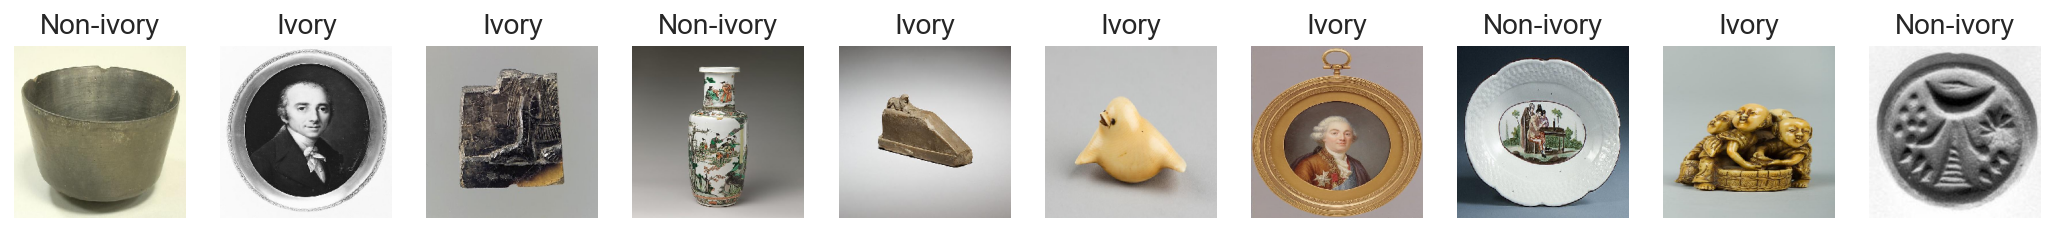

In [84]:
np.random.seed(10)
random_correct_10 = np.random.choice(correct_pred_indices, 10)

plot_images(test_images[random_correct_10], titles=test_labels[random_correct_10])

### Plot 10 Images of Incorrectly Predicted Artifacts

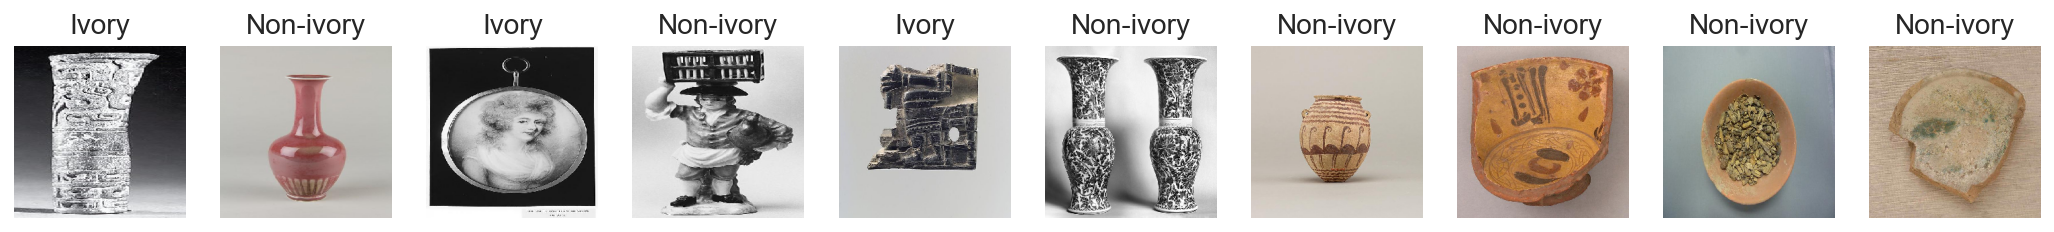

In [85]:
np.random.seed(10)
random_incorrect_10 = np.random.choice(incorrect_pred_indices, 10)

plot_images(test_images[random_incorrect_10], titles=test_labels[random_incorrect_10])